# A Practical Guide for Single-Cell Data Analysis in Neurosciences

## What You'll Learn
- Complete scRNA-seq analysis pipeline from raw data to biological insights
- Parameter optimization strategies for each analysis step
- Integration with pathway analysis and functional annotation tools
- Performance optimization using GPU acceleration
- Troubleshooting common issues

## Project Configuration

In [1]:
# Mount Google Drive (only mounts if not mounted already)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up main working directory
import os
working_dir = "/content/drive/MyDrive/01-Projects/sc-neuro"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

In [4]:
# Define folder structure
folders = [
    "raw_data",
    "processed_data",
    "results",
    "results/figures",
    "results/tables"
]

# Create folders
for folder in folders:
    path = os.path.join(working_dir, folder)
    os.makedirs(path, exist_ok=True)

In [5]:
# Set Save paths for easy use later
raw_data_dir = os.path.join(working_dir, "raw_data")
processed_data_dir = os.path.join(working_dir, "processed_data")
results_dir = os.path.join(working_dir, "results")
figures_dir = os.path.join(working_dir, "results/figures")
tables_dir = os.path.join(working_dir, "results/tables")

## Environment Setup

In [6]:
%%capture
!pip install scanpy
!pip install pandas numpy matplotlib seaborn
!pip install leidenalg python-igraph
!pip install bbknn scvelo cellrank
!pip install decoupler-py gseapy

## GPU Support Installation (Optional but Recommended)


In [7]:
# Colab comes with CUDA preinstalled (check via !nvidia-smi)
!nvidia-smi

Fri Jan  9 02:57:26 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Install CuPy (GPU array library, matches Colab CUDA runtime)
%%capture
!pip install cupy-cuda11x

# RAPIDS SingleCell (still experimental in Colab, but works with recent CUDA runtimes)
!pip install rapids-singlecell

## Additional Analysis Tools

In [9]:
%%capture
# Pathway & regulatory analysis
!pip install gseapy pyscenic
!pip install celltypist scarches

# Visualization
!pip install plotly nbformat>=4.2.0

# Data integration
!pip install harmony-pytorch scanorama

In [10]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Imports
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [12]:
# Set the SCIPY_ARRAY_API environment variable
os.environ["SCIPY_ARRAY_API"] = "1"

# Configure scanpy settings
sc.settings.verbosity = 3  # Verbosity level
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.n_jobs = -1  # Use all available cores

# Memory optimization
sc.settings.max_memory = 50  # GB, adjust based on your system

In [13]:
# GPU configuration (if available)
# The following import caused an AttributeError due to a potential circular import in cuml.
# Temporarily disabling to allow the notebook to proceed.
try:
    import rapids_singlecell as rsc
    import cupy as cp
    GPU_AVAILABLE = True
    print("GPU acceleration enabled!")
except ImportError:
     GPU_AVAILABLE = False
     print("Running on CPU")
GPU_AVAILABLE = False # Set to False as GPU import is skipped.
print("Running on CPU")

Running on CPU
Running on CPU


In [53]:
# Set up plotting parameters
import matplotlib
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams['pdf.fonttype'] = 42  # For publication-quality figures

## Data Acquisition


## Downloading Public Datasets

In [14]:
sc.__version__

'1.11.5'

## GEO Datasets

In [ ]:
# Method 1: Using scanpy built-in datasets
# show all built-in datasets in scanpy
list(sc.datasets.__dict__.keys())

['__name__',
 '__doc__',
 '__package__',
 '__loader__',
 '__spec__',
 '__path__',
 '__file__',
 '__cached__',
 '__builtins__',
 'annotations',
 '_utils',
 '_datasets',
 'blobs',
 'burczynski06',
 'krumsiek11',
 'moignard15',
 'paul15',
 'pbmc3k',
 'pbmc3k_processed',
 'pbmc68k_reduced',
 'toggleswitch',
 'visium_sge',
 '_ebi_expression_atlas',
 'ebi_expression_atlas',
 '__all__']

In [ ]:
# load built-in data
adata = sc.datasets.pbmc3k()  # 3k PBMCs from 10X Genomics

try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [ ]:
%%capture
!pip install GEOparse

In [ ]:
# Method 2: Download from GEO
import GEOparse
import urllib.request

def download_geo_data(geo_id, output_dir=raw_data_dir):
    """
    Download data from GEO database

    Parameters:
    -----------
    geo_id : str
        GEO accession number (e.g., 'GSE123456')
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    gse = GEOparse.get_GEO(geo=geo_id, destdir=output_dir)

    # Get supplementary files
    for gsm_name, gsm in gse.gsms.items():
        # Check if supplementary_file_url attribute exists before accessing it
        if hasattr(gsm, 'supplementary_file_url'):
            for supp_file in gsm.supplementary_file_url:
                try:
                    urllib.request.urlretrieve(supp_file,
                                               f"{output_dir}/{gsm_name}_{supp_file.split('/')[-1]}")
                except Exception as e:
                    print(f"Error downloading supplementary file {supp_file}: {e}")
        else:
            print(f"GSM {gsm_name} does not have the attribute 'supplementary_file_url'. Available attributes are: {dir(gsm)}")

    return gse

In [ ]:
# Example usage
gse = download_geo_data('GSE123456')

06-Jan-2026 15:37:37 DEBUG utils - Directory /content/drive/MyDrive/01-Projects/sc-neuro/raw_data already exists. Skipping.
DEBUG:GEOparse:Directory /content/drive/MyDrive/01-Projects/sc-neuro/raw_data already exists. Skipping.
06-Jan-2026 15:37:37 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE123nnn/GSE123456/soft/GSE123456_family.soft.gz to /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSE123456_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE123nnn/GSE123456/soft/GSE123456_family.soft.gz to /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSE123456_family.soft.gz
100%|██████████| 69.9M/69.9M [00:02<00:00, 27.5MB/s]
06-Jan-2026 15:37:41 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
06-Jan-2026 15:37:41 DEBUG downloader - Moving /tmp/tmp12rdxjtf to /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSE123456_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp12rdxjtf to /content/drive/MyD

GSM GSM3504366 does not have the attribute 'supplementary_file_url'. Available attributes are: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__metaclass__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_columns_as_string', '_get_metadata_as_string', '_get_object_as_soft', '_get_table_as_string', 'annotate', 'annotate_and_average', 'columns', 'download_SRA', 'download_supplementary_files', 'geotype', 'get_accession', 'get_metadata_attribute', 'get_type', 'head', 'metadata', 'name', 'relations', 'show_columns', 'show_metadata', 'show_table', 'table', 'to_soft']
GSM GSM3504367 does not have the attribute 'supplementary_file_url'. Available attributes are: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', 

In [ ]:
gse

<SERIES: GSE123456 - 4 SAMPLES, 1 d(s)>

## 10X Genomics Datasets

In [71]:
# Method 3: Loading 10X Genomics Data
def load_10x_data(data_path, min_genes=200, min_cells=3):
    """
    Load 10X Genomics data with initial filtering

    Parameters:
    -----------
    data_path : str
        Path to the directory containing matrix.mtx, genes.tsv, barcodes.tsv
    min_genes : int
        Minimum number of genes expressed per cell
    min_cells : int
        Minimum number of cells expressing a gene
    """
    # Read 10X data
    adata = sc.read_10x_h5(
        data_path
    )

    # Make variable names unique
    adata.var_names_make_unique()

    # Initial filtering
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    print(f"Loaded dataset: {adata.shape[0]} cells × {adata.shape[1]} genes")

    return adata

In [72]:
os.listdir(raw_data_dir)

['GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5',
 'GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5',
 'GSE123456_family.soft.gz']

In [73]:
# Example usage
# load one sample data from raw_data_dir using load_10x_data
adata = load_10x_data(os.path.join(raw_data_dir, 'GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5'))

reading /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5
 (0:00:00)
filtered out 1 cells that have less than 200 genes expressed
filtered out 11293 genes that are detected in less than 3 cells
Loaded dataset: 6551 cells × 16705 genes


In [74]:
adata

AnnData object with n_obs × n_vars = 6551 × 16705
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

## Loading Multiple Samples

In [75]:
def load_multiple_samples(sample_dict, batch_key='batch'):
    """
    Load and concatenate multiple samples

    Parameters:
    -----------
    sample_dict : dict
        Dictionary with sample names as keys and paths as values
    batch_key : str
        Key to store batch information
    """
    adatas = {}

    for sample_name, path in sample_dict.items():
        print(f"Loading {sample_name}...")
        # Using the updated load_10x_data function which handles both .h5 and mtx
        adata = load_10x_data(path)
        adata.obs[batch_key] = sample_name
        adatas[sample_name] = adata

    # Concatenate all samples, using the dictionary keys for labels and storing them in batch_key column
    adata_concat = sc.concat(adatas, label=batch_key)

    print(f"Combined dataset: {adata_concat.shape[0]} cells × {adata_concat.shape[1]} genes")

    return adata_concat

In [76]:
# Example usage
samples = {
    'S1_WT': os.path.join(raw_data_dir, 'GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5'),
    'S2_Fefz2-KO': os.path.join(raw_data_dir, 'GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5')
}
samples

{'S1_WT': '/content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5',
 'S2_Fefz2-KO': '/content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5'}

In [77]:
adata = load_multiple_samples(samples)

Loading S1_WT...
reading /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5
 (0:00:00)
filtered out 1 cells that have less than 200 genes expressed
filtered out 11293 genes that are detected in less than 3 cells
Loaded dataset: 6551 cells × 16705 genes
Loading S2_Fefz2-KO...
reading /content/drive/MyDrive/01-Projects/sc-neuro/raw_data/GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5
 (0:00:01)
filtered out 9 cells that have less than 200 genes expressed
filtered out 9387 genes that are detected in less than 3 cells
Loaded dataset: 8377 cells × 18611 genes
Combined dataset: 14928 cells × 16576 genes


In [78]:
adata

AnnData object with n_obs × n_vars = 14928 × 16576
    obs: 'n_genes', 'batch'

In [79]:
adata.obs

n_genes        batch
AAACCTGAGAGCTTCT-1     2556        S1_WT
AAACCTGAGAGTACCG-1     1489        S1_WT
AAACCTGAGCCCTAAT-1     1910        S1_WT
AAACCTGAGTGGGATC-1     1926        S1_WT
AAACCTGCACAACTGT-1     2893        S1_WT
...                     ...          ...
TTTGTTGCAATACAGA-1     3249  S2_Fefz2-KO
TTTGTTGGTACCAATC-1     1595  S2_Fefz2-KO
TTTGTTGGTATGATCC-1     2585  S2_Fefz2-KO
TTTGTTGGTGATTAGA-1     2141  S2_Fefz2-KO
TTTGTTGGTTAATCGC-1      658  S2_Fefz2-KO

[14928 rows x 2 columns]

## Quality Control


### Comprehensive QC Metrics

In [80]:
import numpy as np
import scanpy as sc
import scipy
import matplotlib.pyplot as plt


def calculate_qc_metrics(
    adata,
    mt_prefix="mt-",
    rb_prefix="Rps|Rpl",
    hb_genes=["Hba-a1", "Hba-a2", "Hbb-bs"],
    min_genes=200,
    max_genes=2500,
    max_mt_percent=5,
):
    """
    Calculate and visualize comprehensive single-cell QC metrics.

    Gene naming conventions:
    -------------------------
    Mitochondrial genes:
        - Mouse: 'mt-'
        - Human: 'MT-'

    Ribosomal genes:
        - Mouse: 'Rps', 'Rpl'
        - Human: 'RPS', 'RPL'

    Hemoglobin genes:
        - Mouse: Hba-a1, Hba-a2, Hbb-bs
        - Human: HBA1, HBA2, HBB

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    mt_prefix : str
        Prefix for mitochondrial genes
    rb_prefix : str
        Regex pattern for ribosomal genes
    hb_genes : list
        List of hemoglobin genes
    min_genes : int
        Minimum genes per cell (visual guide)
    max_genes : int
        Maximum genes per cell (visual guide)
    max_mt_percent : float
        Maximum mitochondrial percentage (visual guide)
    """

    # Identify gene categories
    adata.var["mt"] = adata.var_names.str.startswith(mt_prefix)
    adata.var["ribo"] = adata.var_names.str.contains(f"^({rb_prefix})")
    adata.var["hb"] = adata.var_names.isin(hb_genes)

    # Compute QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo", "hb"],
        percent_top=None,
        log1p=False,
        inplace=True,
    )

    # Additional metrics
    if scipy.sparse.issparse(adata.X):
        adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1
    else:
        adata.obs["n_genes"] = (adata.X > 0).sum(axis=1)

    adata.obs["log10_total_counts"] = np.log10(adata.obs["total_counts"] + 1)

    # QC violin plots (Scanpy-managed)
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
        jitter=0.4,
        multi_panel=True,
        show=True,
    )

    # Custom diagnostic plots
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    # Counts vs genes
    axes[0].scatter(
        adata.obs["total_counts"],
        adata.obs["n_genes_by_counts"],
        c=adata.obs["pct_counts_mt"],
        s=2,
        alpha=0.5,
    )
    axes[0].set_xlabel("Total counts")
    axes[0].set_ylabel("Genes per cell")

    # Gene count distribution
    axes[1].hist(adata.obs["n_genes_by_counts"], bins=50, alpha=0.7)
    axes[1].axvline(min_genes, color="red", linestyle="--")
    axes[1].axvline(max_genes, color="red", linestyle="--")
    axes[1].set_xlabel("Genes per cell")

    # Mitochondrial percentage
    axes[2].hist(adata.obs["pct_counts_mt"], bins=50, alpha=0.7)
    axes[2].axvline(max_mt_percent, color="red", linestyle="--")
    axes[2].set_xlabel("Mitochondrial %")

    # Library complexity
    axes[3].scatter(
        adata.obs["log10_total_counts"],
        adata.obs["n_genes_by_counts"] / adata.obs["total_counts"],
        s=2,
        alpha=0.5,
    )
    axes[3].set_xlabel("log10(total counts)")
    axes[3].set_ylabel("Genes per UMI")

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nQC summary:")
    print(f"Cells: {adata.n_obs}")
    print(f"Median genes per cell: {adata.obs['n_genes_by_counts'].median():.0f}")
    print(f"Median counts per cell: {adata.obs['total_counts'].median():.0f}")
    print(f"Median MT%: {adata.obs['pct_counts_mt'].median():.2f}")

    return adata

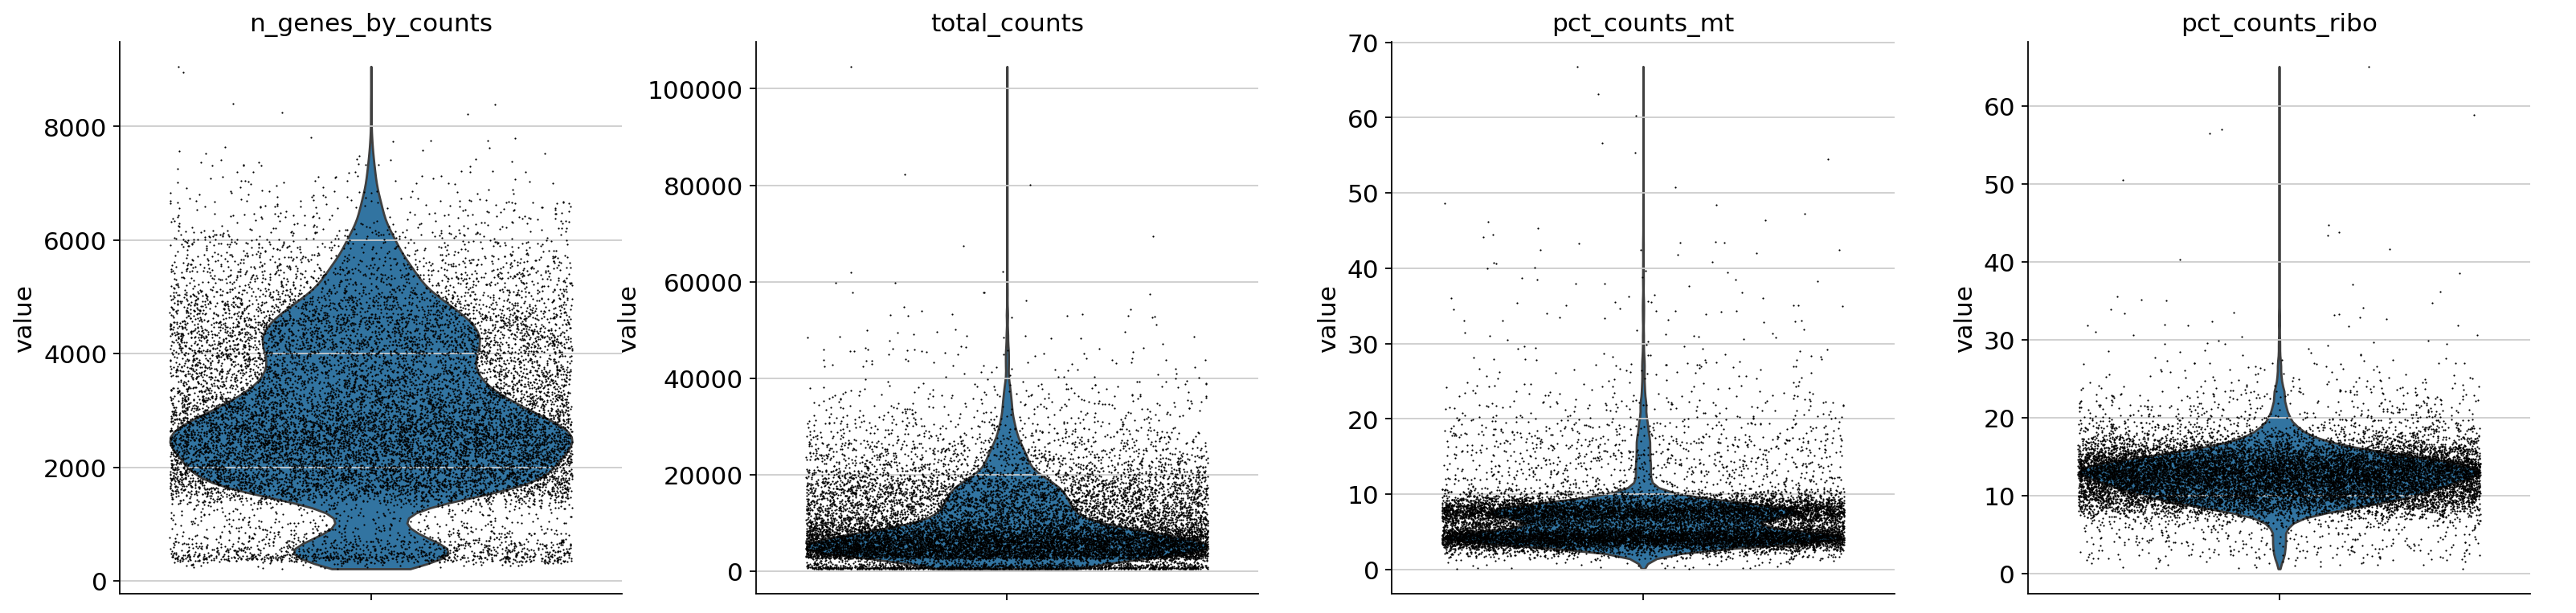

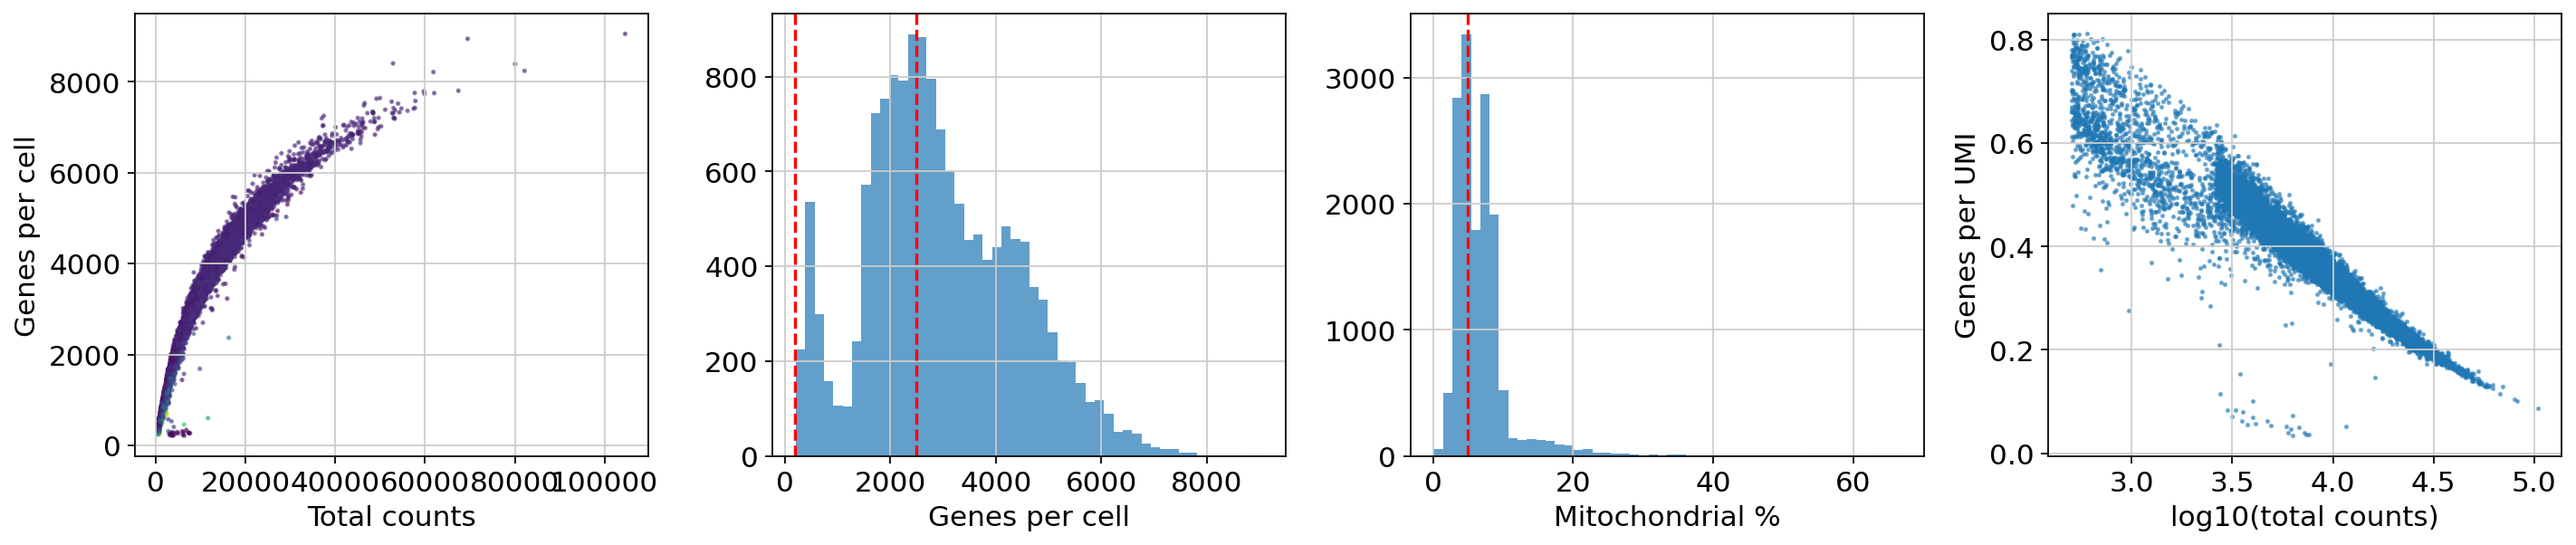


QC summary:
Cells: 14928
Median genes per cell: 2769
Median counts per cell: 7284
Median MT%: 5.99


In [81]:
# Apply QC metrics
adata = calculate_qc_metrics(adata)

## Adaptive Filtering

In [82]:
def adaptive_filtering(adata,
                       mad_threshold=5,
                       min_genes=200,
                       min_counts=500):
    """
    Apply adaptive filtering based on MAD (Median Absolute Deviation)

    Parameters:
    -----------
    mad_threshold : float
        Number of MADs from median for outlier detection
    """
    from scipy import stats

    # Calculate MAD-based thresholds
    def mad_based_outlier(data, threshold=3):
        median = np.median(data)
        mad = stats.median_abs_deviation(data)
        lower = median - threshold * mad
        upper = median + threshold * mad
        return lower, upper

    # Calculate thresholds
    n_genes_lower, n_genes_upper = mad_based_outlier(adata.obs['n_genes_by_counts'], mad_threshold)
    counts_lower, counts_upper = mad_based_outlier(adata.obs['total_counts'], mad_threshold)
    mt_lower, mt_upper = mad_based_outlier(adata.obs['pct_counts_mt'], mad_threshold)

    # Apply minimum thresholds
    n_genes_lower = max(n_genes_lower, min_genes)
    counts_lower = max(counts_lower, min_counts)

    print(f"Adaptive thresholds:")
    print(f"  Genes: {n_genes_lower:.0f} - {n_genes_upper:.0f}")
    print(f"  Counts: {counts_lower:.0f} - {counts_upper:.0f}")
    print(f"  MT%: 0 - {mt_upper:.2f}")

    # Filter cells
    adata = adata[
        (adata.obs['n_genes_by_counts'] >= n_genes_lower) &
        (adata.obs['n_genes_by_counts'] <= n_genes_upper) &
        (adata.obs['total_counts'] >= counts_lower) &
        (adata.obs['total_counts'] <= counts_upper) &
        (adata.obs['pct_counts_mt'] < mt_upper)
    ].copy()

    print(f"Cells after filtering: {adata.n_obs}")

    return adata

In [83]:
# Apply adaptive filtering
adata = adaptive_filtering(adata)

Adaptive thresholds:
  Genes: 200 - 7479
  Counts: 500 - 25750
  MT%: 0 - 15.38
Cells after filtering: 13604


## Normalization and Feature Selection


### Normalization Methods

In [84]:
def normalize_data(adata,
                  method='standard',
                  target_sum=1e4,
                  exclude_highly_expressed=True):
    """
    Normalize expression data with multiple method options

    Parameters:
    -----------
    method : str
        'standard', 'scran', or 'sctransform'
    target_sum : float
        Target sum for normalization
    exclude_highly_expressed : bool
        Whether to exclude highly expressed genes from normalization
    """

    # Save raw counts as a true copy
    adata.raw = adata.copy() # Changed to .copy()

    if method == 'standard':
        # Standard log-normalization
        sc.pp.normalize_total(adata, target_sum=target_sum,
                             exclude_highly_expressed=exclude_highly_expressed)
        sc.pp.log1p(adata)

    elif method == 'scran':
        # scran pooling-based size factor normalization
        import scanpy.external as sce

        # Preliminary clustering for size factor calculation
        adata_pp = adata.copy()
        sc.pp.normalize_total(adata_pp, target_sum=target_sum)
        sc.pp.log1p(adata_pp)
        sc.pp.pca(adata_pp, n_comps=15)
        sc.pp.neighbors(adata_pp)
        sc.tl.leiden(adata_pp, resolution=0.5)

        # Calculate size factors
        adata.obs['size_factors'] = sce.pp.scran_normalize(
            adata,
            clusters=adata_pp.obs['leiden'],
            return_size_factors=True
        )

        # Normalize with size factors
        adata.X /= adata.obs['size_factors'].values[:, None]
        sc.pp.log1p(adata)

    elif method == 'sctransform':
        # SCTransform normalization
        try:
            import scanpy.external as sce
            sce.pp.sctransform(adata)
        except ImportError:
            print("SCTransform not available, using standard normalization")
            sc.pp.normalize_total(adata, target_sum=target_sum)
            sc.pp.log1p(adata)

    print(f"Normalization complete using {method} method")
    return adata

In [85]:
# Apply normalization(standard)
adata = normalize_data(adata, method='standard')

normalizing counts per cell
The following highly-expressed genes are not considered during normalization factor computation:
['Tmsb4x', 'Actb', 'Npy', 'Hbb-bt', 'Hbb-bs', 'Fabp7', 'Hba-a1', 'Hba-a2', 'Gm42418', 'Malat1', 'mt-Atp6']
    finished (0:00:00)
Normalization complete using standard method


In [88]:
adata

AnnData object with n_obs × n_vars = 13604 × 16576
    obs: 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### Highly Variable Gene Selection

In [121]:
def select_highly_variable_genes(adata,
                                 method='seurat',
                                 n_top_genes=2000,
                                 min_mean=0.0125,
                                 max_mean=3,
                                 min_disp=0.5,
                                 batch_key=None):
    """
    Select highly variable genes with different methods

    Parameters:
    -----------
    method : str
        'seurat', 'cell_ranger', or 'seurat_v3'
    n_top_genes : int
        Number of highly variable genes to select
    batch_key : str
        Key for batch correction in HVG selection
    """

    if batch_key:
        # Batch-aware HVG selection
        sc.pp.highly_variable_genes(
            adata,
            n_top_genes=n_top_genes,
            flavor=method,
            batch_key=batch_key,
            subset=False
        )
    else:
        # Standard HVG selection
        sc.pp.highly_variable_genes(
            adata,
            min_mean=min_mean,
            max_mean=max_mean,
            min_disp=min_disp,
            n_top_genes=n_top_genes,
            flavor=method,
            subset=False
        )

    # Plot HVG selection
    sc.pl.highly_variable_genes(adata)

    # Print statistics
    print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")

    # Store full data and filter
    # The adata.raw attribute should be set ONCE, typically after filtering raw counts,
    # and should NOT be overwritten with normalized data.
    # The 'normalize_data' function already sets adata.raw to a copy of the filtered raw counts,
    # so this line below is incorrect and causes the issue.
    # adata.raw = adata # <--- REMOVING THIS LINE
    adata = adata[:, adata.var['highly_variable']]

    return adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


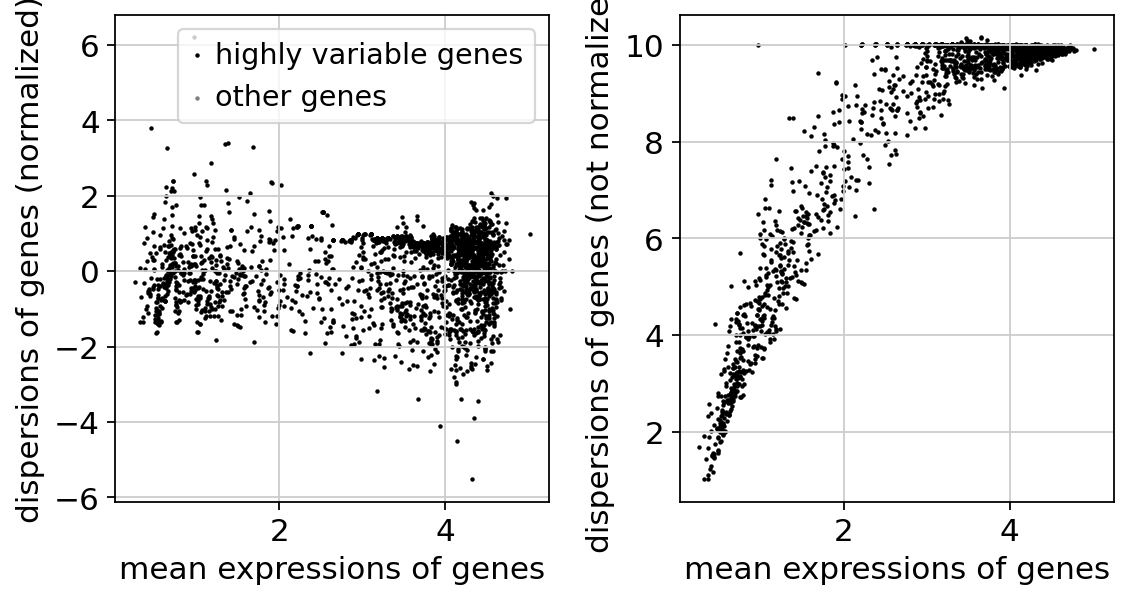

Number of highly variable genes: 2000


In [122]:
# Select HVGs
adata = select_highly_variable_genes(adata, n_top_genes=2000)

## Data Scaling and Regression

In [91]:
def scale_data(adata,
              vars_to_regress=None,
              max_value=10,
              use_gpu=False):
    """
    Scale data and optionally regress out unwanted sources of variation

    Parameters:
    -----------
    vars_to_regress : list
        Variables to regress out (e.g., ['total_counts', 'pct_counts_mt'])
    max_value : float
        Clip values exceeding this threshold
    use_gpu : bool
        Use GPU acceleration if available
    """

    if use_gpu and GPU_AVAILABLE:
        import rapids_singlecell as rsc
        rsc.pp.scale(adata, max_value=max_value)

        if vars_to_regress:
            rsc.pp.regress_out(adata, vars_to_regress)
    else:
        # Scale to unit variance
        sc.pp.scale(adata, max_value=max_value)

        # Regress out unwanted sources of variation
        if vars_to_regress:
            sc.pp.regress_out(adata, vars_to_regress)

    print(f"Data scaled. Max value: {max_value}")
    if vars_to_regress:
        print(f"Regressed out: {vars_to_regress}")

    return adata

In [92]:
adata.obs

n_genes        batch  n_genes_by_counts  total_counts  \
AAACCTGAGAGCTTCT-1     2555        S1_WT               2555        6800.0   
AAACCTGAGAGTACCG-1     1489        S1_WT               1489        3213.0   
AAACCTGAGCCCTAAT-1     1909        S1_WT               1909        4085.0   
AAACCTGAGTGGGATC-1     1926        S1_WT               1926        4511.0   
AAACCTGCACAACTGT-1     2892        S1_WT               2892        8405.0   
...                     ...          ...                ...           ...   
TTTGTTGAGCGTTCAT-1     4778  S2_Fefz2-KO               4778       19368.0   
TTTGTTGCAATACAGA-1     3248  S2_Fefz2-KO               3248        8002.0   
TTTGTTGGTACCAATC-1     1591  S2_Fefz2-KO               1591        2769.0   
TTTGTTGGTATGATCC-1     2584  S2_Fefz2-KO               2584        6194.0   
TTTGTTGGTGATTAGA-1     2140  S2_Fefz2-KO               2140        5284.0   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCTGAGAGCTTCT-1            374.0       5.500000              882.0   
AAACCTGAGAGTACCG-1            278.0       8.652349              481.0   
AAACCTGAGCCCTAAT-1             99.0       2.423501              595.0   
AAACCTGAGTGGGATC-1            240.0       5.320328              612.0   
AAACCTGCACAACTGT-1            386.0       4.592505             1484.0   
...                             ...            ...                ...   
TTTGTTGAGCGTTCAT-1           1478.0       7.631144             2119.0   
TTTGTTGCAATACAGA-1            652.0       8.147964              769.0   
TTTGTTGGTACCAATC-1            209.0       7.547851              184.0   
TTTGTTGGTATGATCC-1            383.0       6.183403              743.0   
TTTGTTGGTGATTAGA-1            287.0       5.431491              755.0   

                    pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AAACCTGAGAGCTTCT-1        12.970588              0.0        0.00000   
AAACCTGAGAGTACCG-1        14.970432              0.0        0.00000   
AAACCTGAGCCCTAAT-1        14.565483              1.0        0.02448   
AAACCTGAGTGGGATC-1        13.566836              0.0        0.00000   
AAACCTGCACAACTGT-1        17.656157              0.0        0.00000   
...                             ...              ...            ...   
TTTGTTGAGCGTTCAT-1        10.940727              0.0        0.00000   
TTTGTTGCAATACAGA-1         9.610097              0.0        0.00000   
TTTGTTGGTACCAATC-1         6.644999              0.0        0.00000   
TTTGTTGGTATGATCC-1        11.995480              0.0        0.00000   
TTTGTTGGTGATTAGA-1        14.288418              0.0        0.00000   

                    log10_total_counts  
AAACCTGAGAGCTTCT-1            3.832573  
AAACCTGAGAGTACCG-1            3.507046  
AAACCTGAGCCCTAAT-1            3.611298  
AAACCTGAGTGGGATC-1            3.654369  
AAACCTGCACAACTGT-1            3.924590  
...                                ...  
TTTGTTGAGCGTTCAT-1            4.287107  
TTTGTTGCAATACAGA-1            3.903253  
TTTGTTGGTACCAATC-1            3.442480  
TTTGTTGGTATGATCC-1            3.792042  
TTTGTTGGTGATTAGA-1            3.723045  

[13604 rows x 11 columns]

In [93]:
# Scale data
adata = scale_data(adata, vars_to_regress=['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:00)
Data scaled. Max value: 10
Regressed out: ['total_counts', 'pct_counts_mt']


## Dimensionality Reduction


### Principal Component Analysis (PCA)

In [94]:
%%capture
!pip install kneed

In [95]:
def run_pca(adata,
           n_comps=50,
           use_hvg=True,
           svd_solver='auto',
           random_state=0):
    """
    Run PCA with optimal component selection

    Parameters:
    -----------
    n_comps : int
        Number of principal components
    use_hvg : bool
        Use only highly variable genes
    svd_solver : str
        SVD solver to use ('auto', 'full', 'arpack', 'randomized')
    """

    # Run PCA
    sc.tl.pca(adata, n_comps=n_comps, svd_solver=svd_solver, random_state=random_state)

    # Determine optimal number of PCs
    # Method 1: Elbow plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Adjusted figsize for better display of 3 plots

    # Variance explained
    axes[0].plot(range(1, n_comps+1), adata.uns['pca']['variance_ratio'], 'o-')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Variance Explained Ratio')
    axes[0].set_title('PCA Variance Explained')

    # Cumulative variance
    cumsum_var = np.cumsum(adata.uns['pca']['variance_ratio'])
    axes[1].plot(range(1, n_comps+1), cumsum_var, 'o-')
    axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_ylabel('Cumulative Variance Explained')
    axes[1].set_title('Cumulative Variance')
    axes[1].legend()

    # Find elbow point (simplified)
    from kneed import KneeLocator # Ensure kneed is imported
    try:
        kn = KneeLocator(range(1, n_comps+1),
                        adata.uns['pca']['variance_ratio'],
                        curve='convex',
                        direction='decreasing')
        elbow = kn.elbow
        axes[0].axvline(x=elbow, color='r', linestyle='--', label=f'Elbow at PC{elbow}')
        axes[0].legend()
        print(f"Suggested number of PCs (elbow method): {elbow}")
    except Exception as e:
        print(f"Could not determine elbow point automatically: {e}")

    # Method 2: Plot PCA scatter plot (cells in PC space) on axes[2]
    # Replaced sc.pl.pca_loadings with sc.pl.pca as pca_loadings does not support the 'ax' argument
    # in this scanpy version, but sc.pl.pca does, maintaining the multi-panel figure.
    # Note: This changes the type of plot in the third panel from gene loadings to cell embeddings.
    sc.pl.pca(adata, ax=axes[2], show=False, title='PCA (Cells in PC space)')

    plt.tight_layout()
    plt.show()

    # Additional visualization
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

    return adata

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'`.
    with n_comps=50
    finished (0:00:05)
Suggested number of PCs (elbow method): 9


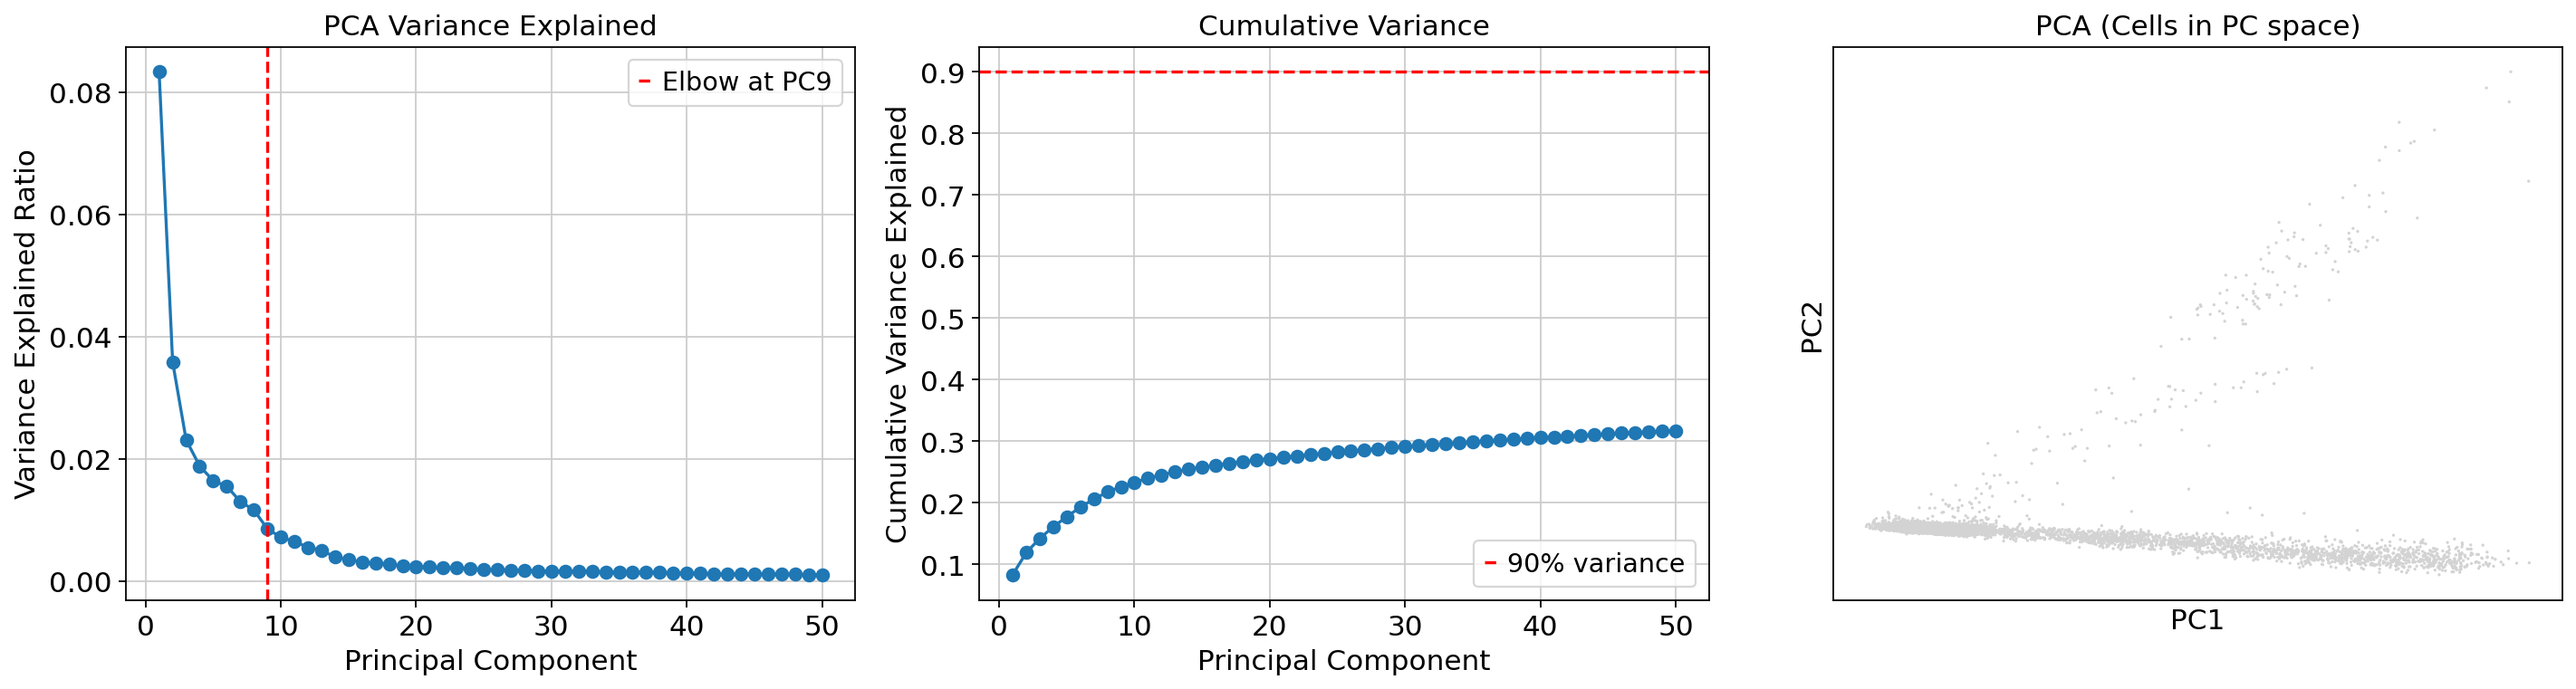

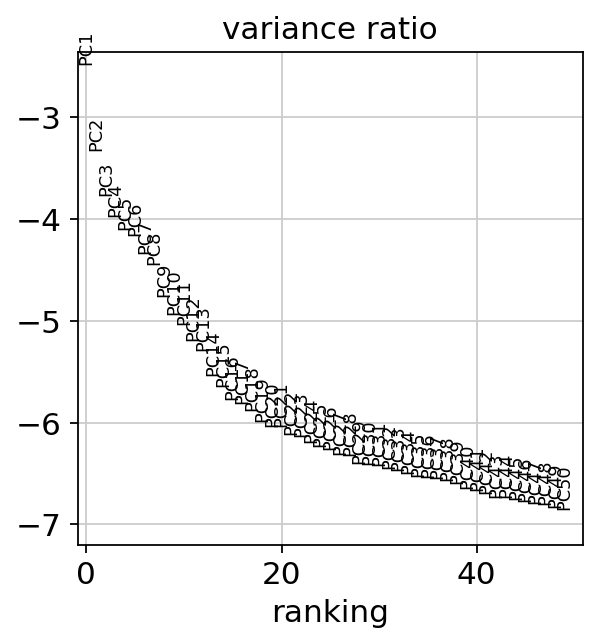

In [96]:
# Run PCA
adata = run_pca(adata, n_comps=50)

### UMAP and t-SNE

In [97]:
def run_umap_tsne(adata,
                 n_neighbors=30,
                 n_pcs=40,
                 min_dist=0.3,
                 spread=1.0,
                 perplexity=30,
                 learning_rate=200,
                 use_gpu=False):
    """
    Run UMAP and t-SNE with parameter optimization

    Parameters:
    -----------
    n_neighbors : int
        Number of neighbors for UMAP
    n_pcs : int
        Number of PCs to use
    min_dist : float
        Minimum distance for UMAP
    spread : float
        Spread parameter for UMAP
    perplexity : int
        Perplexity for t-SNE
    """

    # Compute neighbor graph
    print(f"Computing neighbor graph with {n_neighbors} neighbors...")
    if use_gpu and GPU_AVAILABLE:
        import rapids_singlecell as rsc
        rsc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    else:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

    # Run UMAP
    print("Running UMAP...")
    if use_gpu and GPU_AVAILABLE:
        import rapids_singlecell as rsc
        rsc.tl.umap(adata, min_dist=min_dist, spread=spread)
    else:
        sc.tl.umap(adata, min_dist=min_dist, spread=spread)

    # Run t-SNE
    print("Running t-SNE...")
    if use_gpu and GPU_AVAILABLE:
        import rapids_singlecell as rsc
        rsc.tl.tsne(adata, perplexity=perplexity, learning_rate=learning_rate)
    else:
        sc.tl.tsne(adata, perplexity=perplexity, learning_rate=learning_rate)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sc.pl.umap(adata, ax=axes[0], show=False)
    sc.pl.tsne(adata, ax=axes[1], show=False)
    plt.tight_layout()
    plt.show()

    return adata

Computing neighbor graph with 30 neighbors...
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
Running UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:11)
Running t-SNE...
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:49)


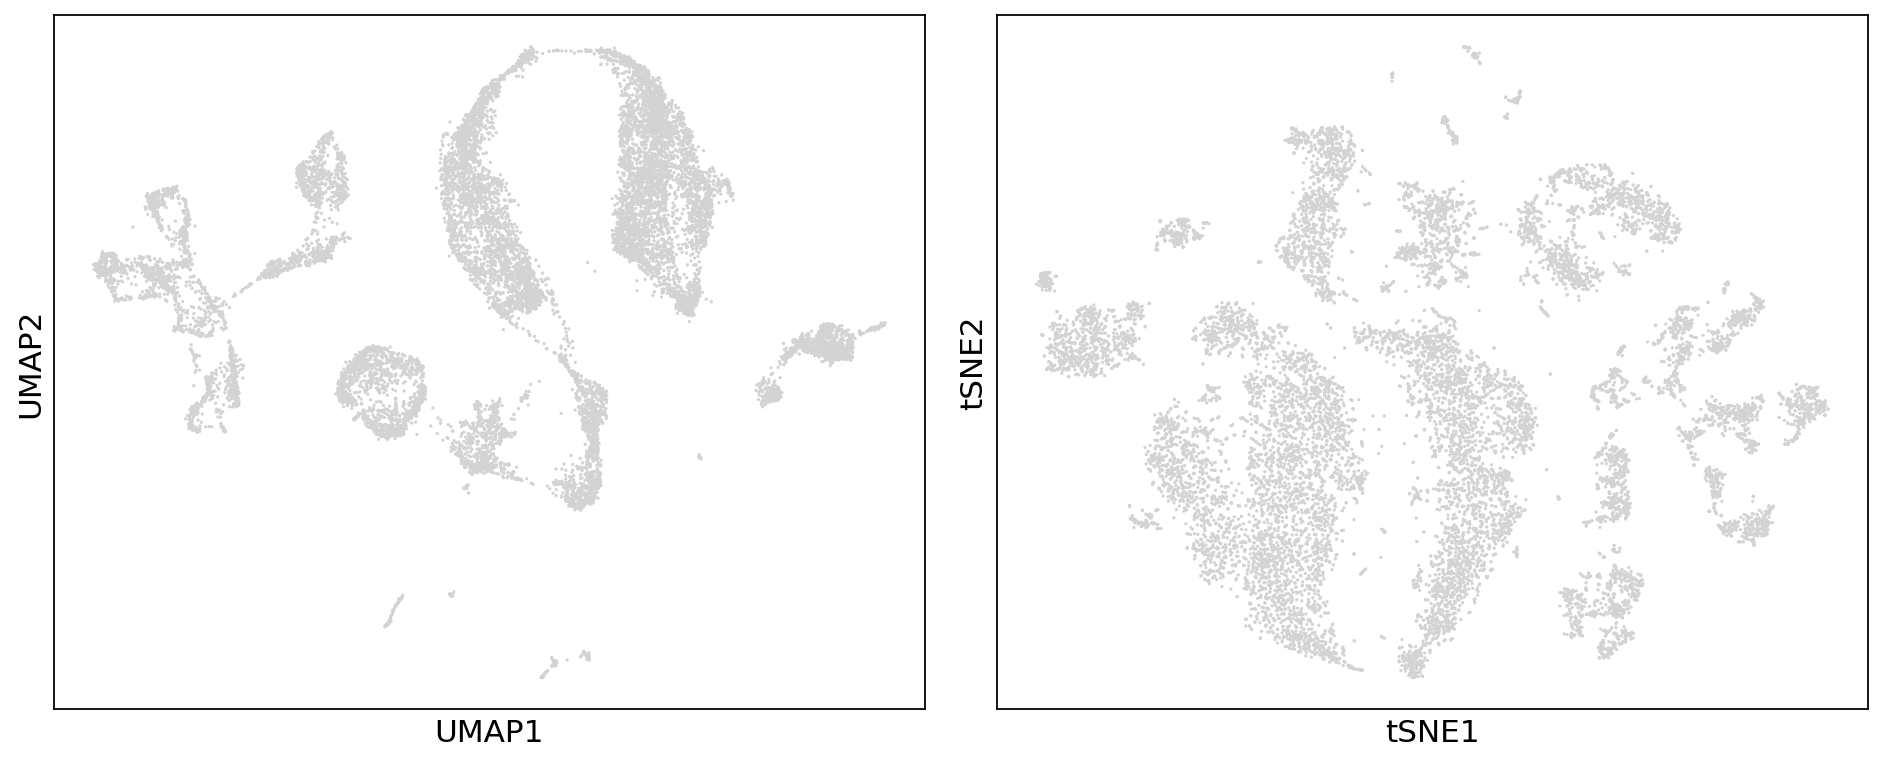

In [98]:
# Run dimensionality reduction (UMAP)
adata = run_umap_tsne(adata, n_neighbors=30, n_pcs=40)

### Diffusion Maps (Alternative)

In [99]:
def run_diffusion_map(adata, n_comps=15):
    """
    Run diffusion map for trajectory analysis
    """
    # Compute diffusion map
    sc.tl.diffmap(adata, n_comps=n_comps)

    # Plot
    sc.pl.diffmap(adata, color='n_genes', components=['1,2', '1,3'])

    return adata

## Clustering Analysis


### Leiden Clustering with Resolution Optimization

In [100]:
def optimize_clustering_resolution(adata,
                                  resolution_range=(0.1, 2.0, 0.1),
                                  n_neighbors=30,
                                  metric='euclidean',
                                  random_state=0):
    """
    Optimize clustering resolution using multiple metrics

    Parameters:
    -----------
    resolution_range : tuple
        (start, stop, step) for resolution search
    """
    import pandas as pd
    from sklearn import metrics

    resolutions = np.arange(*resolution_range)

    # Store metrics
    results = []

    for res in resolutions:
        # Run clustering
        sc.tl.leiden(adata, resolution=res, random_state=random_state, key_added=f'leiden_{res}')

        # Calculate metrics
        labels = adata.obs[f'leiden_{res}'].astype(int)
        n_clusters = len(np.unique(labels))

        # Silhouette score (subsampled for speed)
        if adata.n_obs > 5000:
            subsample_idx = np.random.choice(adata.n_obs, 5000, replace=False)
            sil_score = metrics.silhouette_score(
                adata.obsm['X_pca'][subsample_idx],
                labels[subsample_idx]
            )
        else:
            sil_score = metrics.silhouette_score(adata.obsm['X_pca'], labels)

        # Calinski-Harabasz score
        ch_score = metrics.calinski_harabasz_score(adata.obsm['X_pca'], labels)

        # Davies-Bouldin score (lower is better)
        db_score = metrics.davies_bouldin_score(adata.obsm['X_pca'], labels)

        results.append({
            'resolution': res,
            'n_clusters': n_clusters,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score
        })

    results_df = pd.DataFrame(results)

    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(results_df['resolution'], results_df['n_clusters'], 'o-')
    axes[0, 0].set_xlabel('Resolution')
    axes[0, 0].set_ylabel('Number of Clusters')
    axes[0, 0].set_title('Clusters vs Resolution')

    axes[0, 1].plot(results_df['resolution'], results_df['silhouette'], 'o-')
    axes[0, 1].set_xlabel('Resolution')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score (higher is better)')

    axes[1, 0].plot(results_df['resolution'], results_df['calinski_harabasz'], 'o-')
    axes[1, 0].set_xlabel('Resolution')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Score (higher is better)')

    axes[1, 1].plot(results_df['resolution'], results_df['davies_bouldin'], 'o-')
    axes[1, 1].set_xlabel('Resolution')
    axes[1, 1].set_ylabel('Davies-Bouldin Score')
    axes[1, 1].set_title('Davies-Bouldin Score (lower is better)')

    plt.tight_layout()
    plt.show()

    # Find optimal resolution (based on silhouette score)
    optimal_res = results_df.loc[results_df['silhouette'].idxmax(), 'resolution']
    print(f"\nOptimal resolution (by silhouette score): {optimal_res}")
    print(f"Number of clusters: {results_df.loc[results_df['resolution']==optimal_res, 'n_clusters'].values[0]}")

    # Set final clustering
    adata.obs['leiden'] = adata.obs[f'leiden_{optimal_res}']

    # Clean up temporary clusterings
    for res in resolutions:
        del adata.obs[f'leiden_{res}']

    return adata, results_df

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:06)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden_0.30000000000000004', the cluster labels (adata.obs, categorical) (0:00:08)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:07)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:06)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:11)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_0.7000000000000001', the cluster labels (adata.obs, categorical)

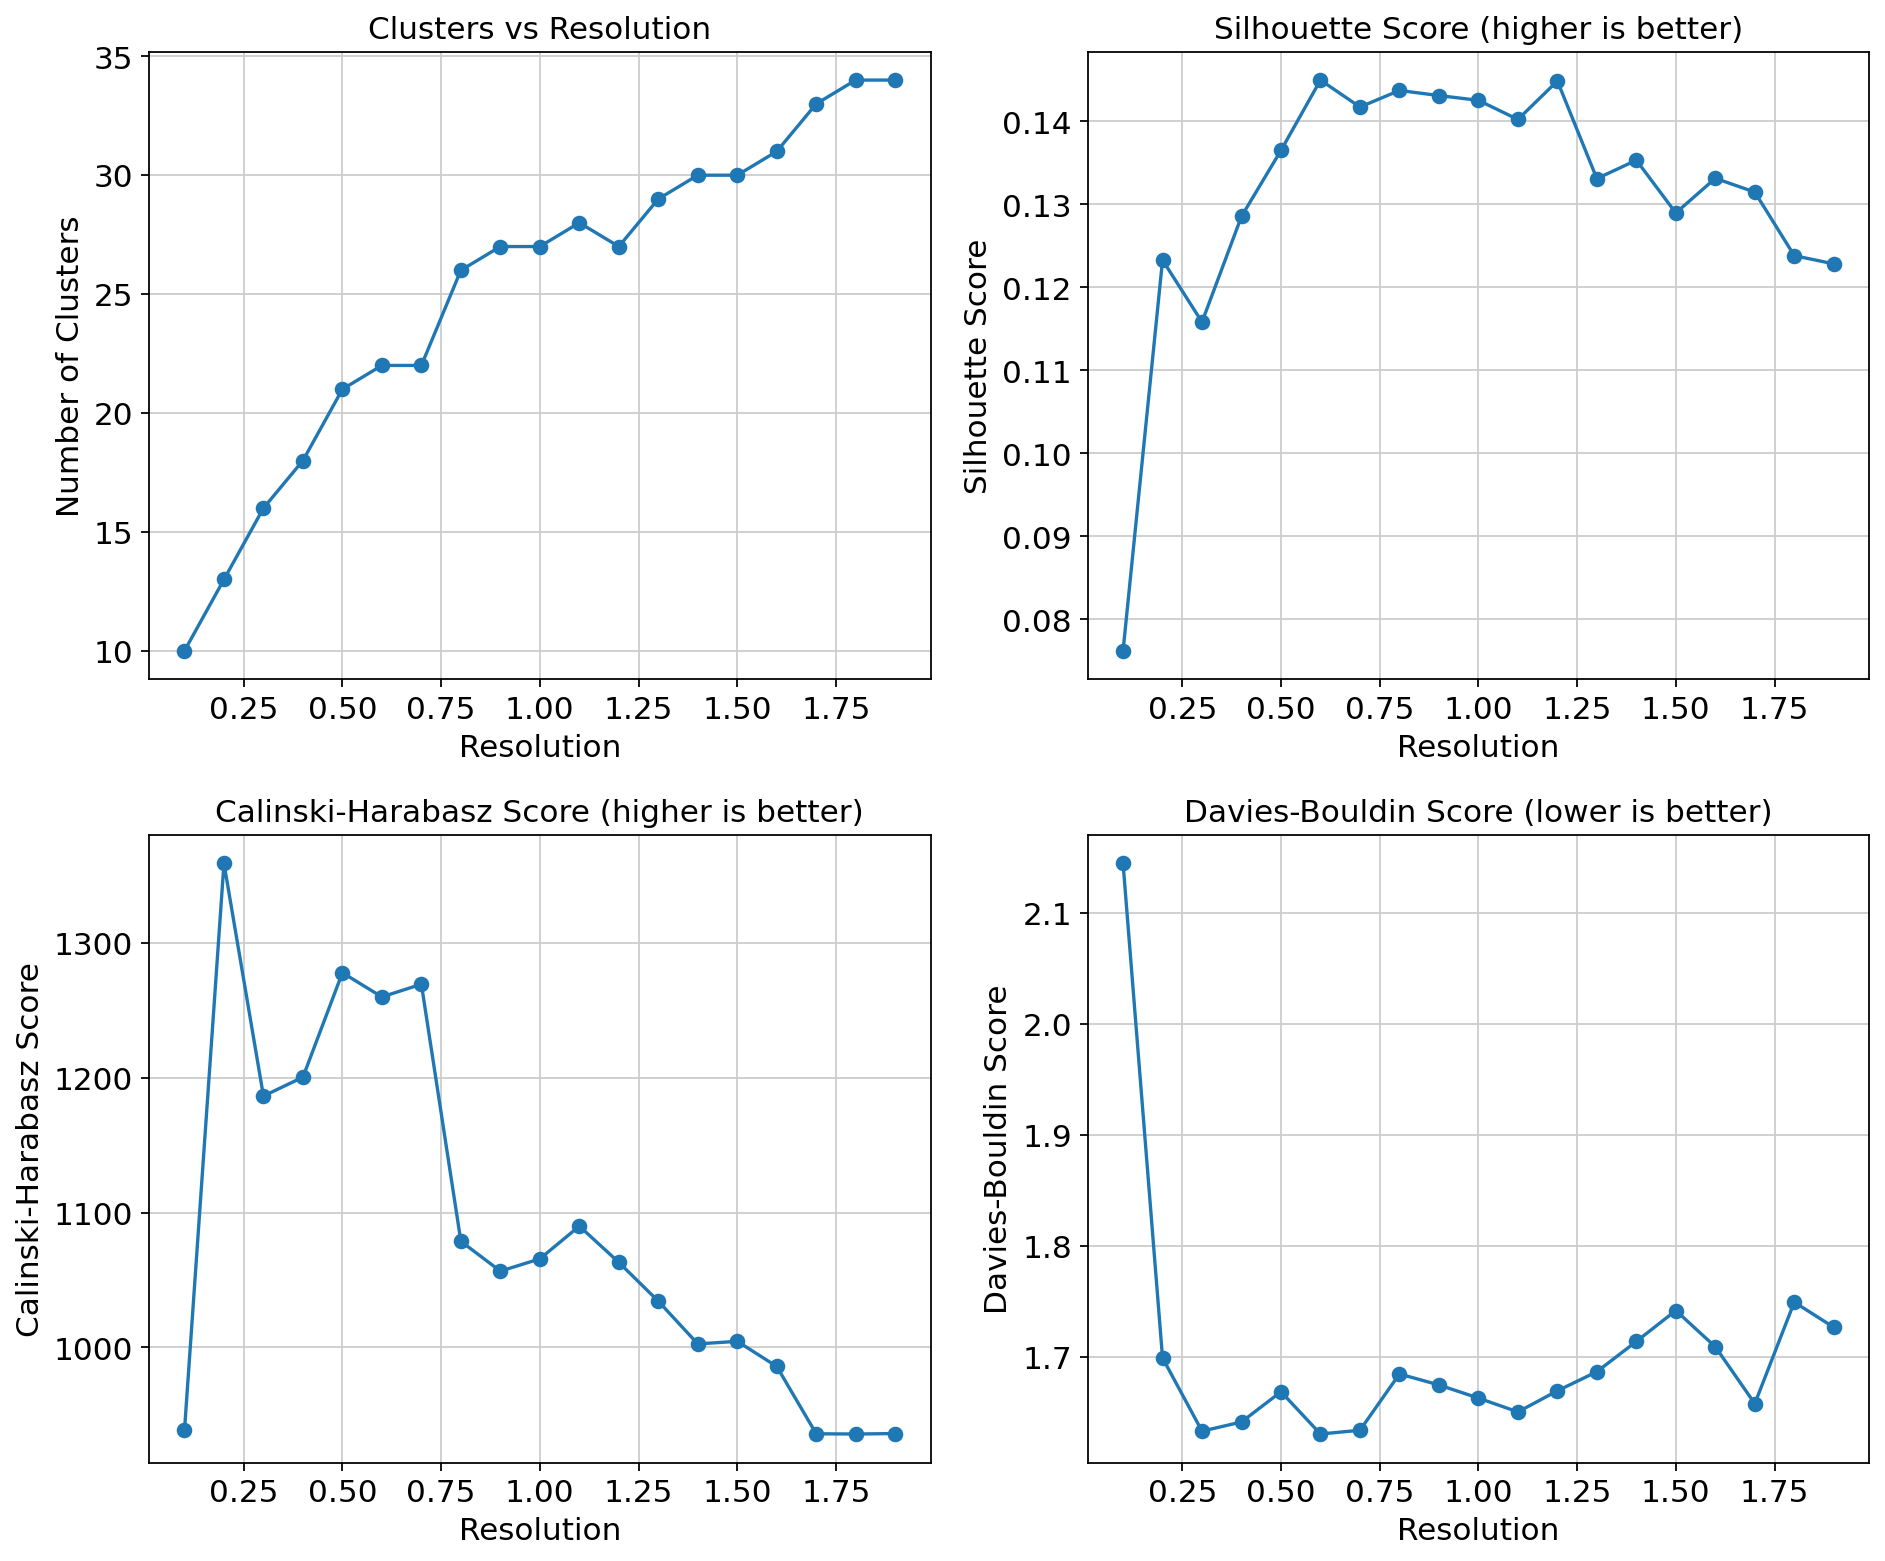


Optimal resolution (by silhouette score): 0.6
Number of clusters: 22


In [101]:
# Optimize clustering
adata, clustering_metrics = optimize_clustering_resolution(adata)

In [107]:
adata

AnnData object with n_obs × n_vars = 13604 × 2000
    obs: 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'leiden', 'celltypist_prediction', 'louvain', 'spectral'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden_0.1', 'leiden_0.2', 'leiden_0.30000000000000004', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7000000000000001', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2000000000000002', 'leiden_1.3000000000000003', 'leiden_1.4000000000000001', 'leiden_1.5000000000000002', 'leiden_1.6', 'leiden_1.7000000000000002', 'leiden_1.8000000000000003', 'leiden_1.9000000000000001', 'leiden', 'louvain', 'leiden_colors', 'louvain_

In [108]:
clustering_metrics

resolution  n_clusters  silhouette  calinski_harabasz  davies_bouldin
0          0.1          10    0.076203         938.405029        2.144520
1          0.2          13    0.123281        1359.031738        1.698886
2          0.3          16    0.115819        1186.384766        1.632922
3          0.4          18    0.128547        1200.386475        1.641202
4          0.5          21    0.136497        1277.842041        1.668434
5          0.6          22    0.144967        1259.895386        1.630353
6          0.7          22    0.141719        1269.343506        1.633750
7          0.8          26    0.143716        1078.651978        1.684441
8          0.9          27    0.143100        1056.501831        1.674566
9          1.0          27    0.142529        1065.628052        1.662719
10         1.1          28    0.140219        1089.902954        1.650264
11         1.2          27    0.144862        1063.031860        1.669273
12         1.3          29    0.133090        1034.227295        1.686478
13         1.4          30    0.135315        1002.548279        1.713764
14         1.5          30    0.128957        1004.440002        1.741604
15         1.6          31    0.133133         985.830383        1.708919
16         1.7          33    0.131468         935.882690        1.657705
17         1.8          34    0.123812         935.704041        1.749150
18         1.9          34    0.122826         936.053528        1.726476

### Alternative Clustering Methods

In [44]:
%%capture
!pip install louvain

In [45]:
def compare_clustering_algorithms(adata, resolution=1.0):
    """
    Compare different clustering algorithms
    """

    # Leiden
    sc.tl.leiden(adata, resolution=resolution, key_added='leiden')

    # Louvain
    sc.tl.louvain(adata, resolution=resolution, key_added='louvain')

    # Spectral clustering
    from sklearn.cluster import SpectralClustering
    spec_clustering = SpectralClustering(
        n_clusters=len(adata.obs['leiden'].unique()),
        affinity='precomputed',
        random_state=0
    )
    connectivity = adata.obsp['connectivities'].toarray()
    adata.obs['spectral'] = spec_clustering.fit_predict(connectivity).astype(str)

    # Visualize all methods
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden')
    sc.pl.umap(adata, color='louvain', ax=axes[1], show=False, title='Louvain')
    sc.pl.umap(adata, color='spectral', ax=axes[2], show=False, title='Spectral')
    plt.tight_layout()
    plt.show()

    return adata

running Leiden clustering
    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


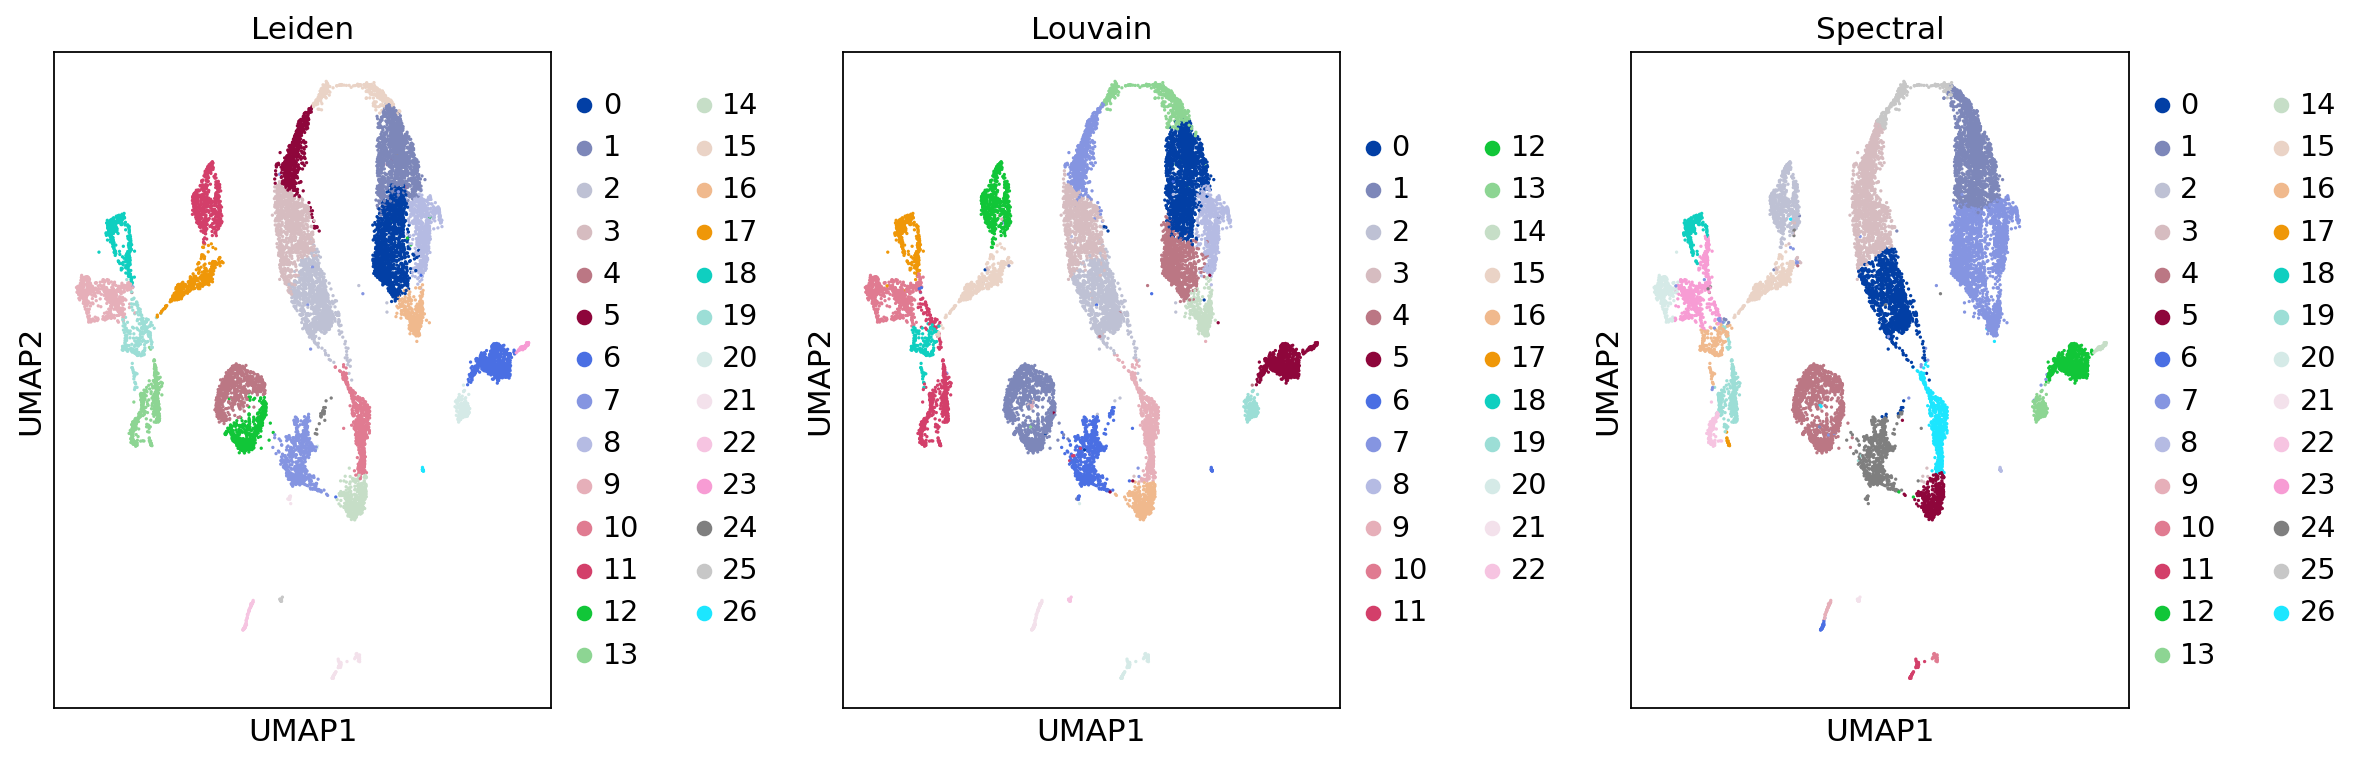

In [105]:
# Compare clustering methods
adata = compare_clustering_algorithms(adata)

## Differential Expression Analysis


### Finding Marker Genes

In [47]:
def find_all_markers(adata,
                    groupby='leiden',
                    method='wilcoxon',
                    min_fold_change=0.25,
                    min_pct=0.1,
                    n_genes=25):
    """
    Find marker genes for all clusters

    Parameters:
    -----------
    method : str
        'wilcoxon', 't-test', 'logreg', or 'wilcoxon_pval'
    min_fold_change : float
        Minimum log fold change
    min_pct : float
        Minimum percentage of cells expressing the gene
    """

    # Calculate marker genes
    print(f"Finding markers using {method} test...")
    sc.tl.rank_genes_groups(
        adata,
        groupby=groupby,
        method=method,
        min_fold_change=min_fold_change,
        n_genes=n_genes,
        use_raw=True
    )

    # Filter by expression percentage
    sc.tl.filter_rank_genes_groups(
        adata,
        min_in_group_fraction=min_pct,
        min_fold_change=min_fold_change
    )

    # Visualize top markers
    sc.pl.rank_genes_groups(adata, n_genes=n_genes, sharey=False)

    # Create marker gene DataFrame
    markers_df = pd.DataFrame()
    for cluster in adata.obs[groupby].unique():
        cluster_genes = pd.DataFrame({
            'gene': adata.uns['rank_genes_groups']['names'][cluster][:n_genes],
            'score': adata.uns['rank_genes_groups']['scores'][cluster][:n_genes],
            'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges'][cluster][:n_genes],
            'pval': adata.uns['rank_genes_groups']['pvals'][cluster][:n_genes],
            'pval_adj': adata.uns['rank_genes_groups']['pvals_adj'][cluster][:n_genes],
            'cluster': cluster
        })
        markers_df = pd.concat([markers_df, cluster_genes])

    # Save markers
    markers_df.to_csv('marker_genes.csv', index=False)
    print(f"Saved marker genes to marker_genes.csv")

    return adata, markers_df

Finding markers using wilcoxon test...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)
Filtering genes using: min_in_group_fraction: 0.1 min_fold_change: 0.25, max_out_group_fraction: 0.5


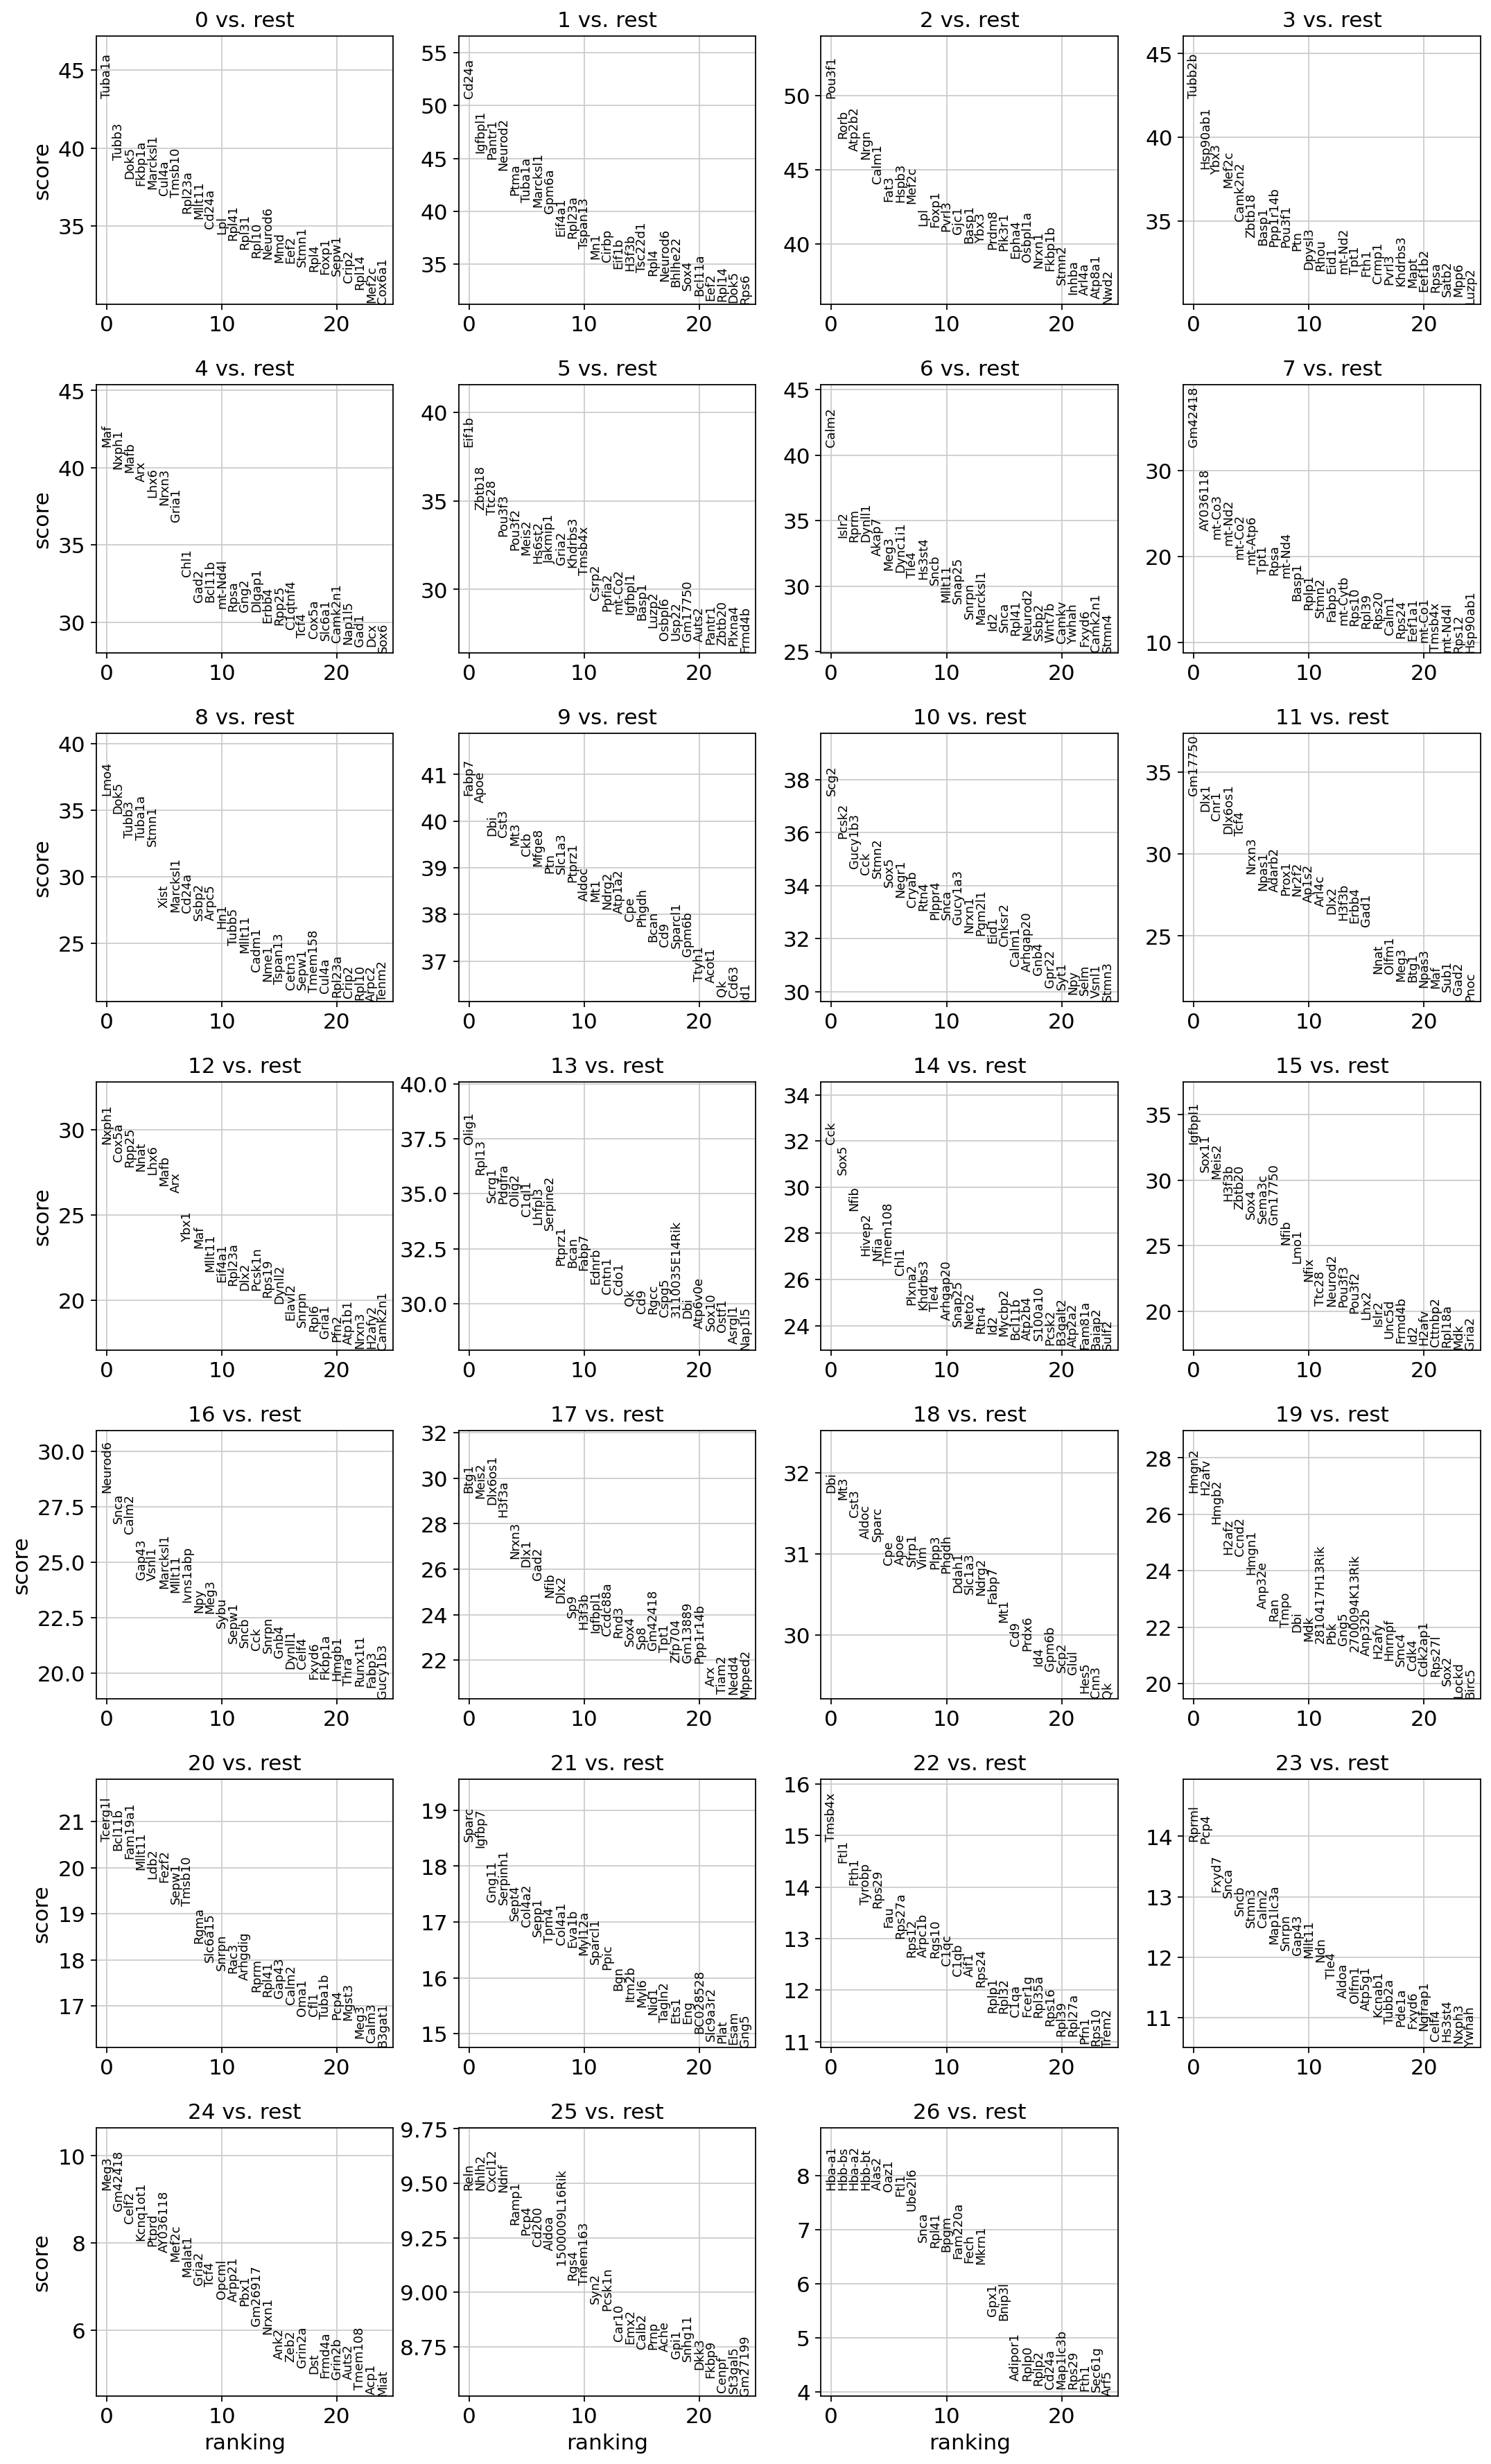

Saved marker genes to marker_genes.csv


In [48]:
# Find markers
adata, markers = find_all_markers(adata)

In [49]:
adata

AnnData object with n_obs × n_vars = 13604 × 2000
    obs: 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'leiden', 'louvain', 'spectral'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden_0.1', 'leiden_0.2', 'leiden_0.30000000000000004', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7000000000000001', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2000000000000002', 'leiden_1.3000000000000003', 'leiden_1.4000000000000001', 'leiden_1.5000000000000002', 'leiden_1.6', 'leiden_1.7000000000000002', 'leiden_1.8000000000000003', 'leiden_1.9000000000000001', 'leiden', 'louvain', 'leiden_colors', 'louvain_colors', 'spectral_colors

In [50]:
markers

gene      score  logfoldchange           pval       pval_adj cluster
0     Tuba1a  43.217850       1.168990   0.000000e+00   0.000000e+00       0
1      Tubb3  39.233707       1.387132   0.000000e+00   0.000000e+00       0
2       Dok5  38.042248       2.027557   0.000000e+00   0.000000e+00       0
3     Fkbp1a  37.593048       1.246262  2.792047e-309  1.157024e-305       0
4   Marcksl1  37.395966       1.347586  4.544113e-306  1.506464e-302       0
..       ...        ...            ...            ...            ...     ...
20     Auts2  27.079414       1.720998  1.721066e-161  1.296745e-158       5
21    Pantr1  26.896795       1.794458  2.394251e-159  1.725526e-156       5
22    Zbtb20  26.854914       2.330478  7.390793e-159  5.104574e-156       5
23    Plxna4  26.823082       2.066755  1.738694e-158  1.152824e-155       5
24    Frmd4b  26.431820       2.868790  5.904859e-154  3.764575e-151       5

[675 rows x 6 columns]

### Visualization of Marker Genes

In [51]:
def visualize_markers(adata, markers_df, n_top=5):
    """
    Create comprehensive marker gene visualizations
    """

    # Get top markers per cluster
    top_markers = markers_df.groupby('cluster').head(n_top)['gene'].unique()

    # Dot plot
    sc.pl.dotplot(adata, top_markers, groupby='leiden',
                  dendrogram=True, standard_scale='var')

    # Heatmap
    sc.pl.heatmap(adata, top_markers, groupby='leiden',
                  swap_axes=True, standard_scale='var', cmap='RdBu_r')

    # Stacked violin plot
    sc.pl.stacked_violin(adata, top_markers, groupby='leiden',
                         dendrogram=True)

    # Matrix plot
    sc.pl.matrixplot(adata, top_markers, groupby='leiden',
                     dendrogram=True, standard_scale='var', cmap='RdBu_r')

    return adata

In [52]:
# Visualize markers
adata = visualize_markers(adata, markers)

Output hidden; open in https://colab.research.google.com to view.

## Cell Type Annotation


###  Manual Annotation with Known Markers

In [109]:
def manual_annotation(adata, marker_dict, groupby='leiden'):
    """
    Manually annotate cell types based on known markers

    Parameters:
    -----------
    marker_dict : dict
        Dictionary with cell types as keys and marker lists as values
    """

    # Example marker dictionary for PBMCs
    if marker_dict is None:
        marker_dict = {
            'CD4 T cells': ['CD3D', 'CD4', 'IL7R'],
            'CD8 T cells': ['CD3D', 'CD8A', 'CD8B'],
            'NK cells': ['GNLY', 'NKG7', 'KLRD1'],
            'B cells': ['MS4A1', 'CD79A', 'CD79B'],
            'Monocytes': ['CD14', 'LYZ', 'S100A8', 'S100A9'],
            'DCs': ['FCER1A', 'CST3', 'CLEC10A'],
            'Platelets': ['PPBP', 'PF4']
        }

    # Score each cell type
    for cell_type, markers in marker_dict.items():
        # Filter markers that exist in the dataset
        valid_markers = [m for m in markers if m in adata.var_names]
        if valid_markers:
            sc.tl.score_genes(adata, valid_markers, score_name=f'{cell_type}_score')

    # Create score matrix
    score_cols = [f'{ct}_score' for ct in marker_dict.keys()]
    score_matrix = adata.obs[score_cols].values

    # Assign cell types based on highest score per cluster
    cluster_annotations = {}
    for cluster in adata.obs[groupby].unique():
        cluster_mask = adata.obs[groupby] == cluster
        cluster_scores = score_matrix[cluster_mask].mean(axis=0)
        best_type = list(marker_dict.keys())[np.argmax(cluster_scores)]
        cluster_annotations[cluster] = best_type

    # Add annotations
    adata.obs['cell_type'] = adata.obs[groupby].map(cluster_annotations)

    # Visualize
    sc.pl.umap(adata, color=['leiden', 'cell_type'], legend_loc='on data')

    return adata

In [56]:
adata

AnnData object with n_obs × n_vars = 13604 × 2000
    obs: 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'leiden', 'louvain', 'spectral'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden_0.1', 'leiden_0.2', 'leiden_0.30000000000000004', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7000000000000001', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2000000000000002', 'leiden_1.3000000000000003', 'leiden_1.4000000000000001', 'leiden_1.5000000000000002', 'leiden_1.6', 'leiden_1.7000000000000002', 'leiden_1.8000000000000003', 'leiden_1.9000000000000001', 'leiden', 'louvain', 'leiden_colors', 'louvain_colors', 'spectral_colors

In [110]:
def manual_annotation(adata, marker_dict, groupby='leiden'):
    """
    Manually annotate cell types based on known markers

    Parameters:
    -----------
    marker_dict : dict
        Dictionary with cell types as keys and marker lists as values
    """

    if marker_dict is None:
        # This block is usually for default, but for this context, it's explicitly passed.
        # Keeping it for consistency with original function structure.
        marker_dict = {
            'CD4 T cells': ['CD3D', 'CD4', 'IL7R'],
            'CD8 T cells': ['CD8A', 'CD8B'],
            'NK cells': ['GNLY', 'NKG7', 'KLRD1'],
            'B cells': ['MS4A1', 'CD79A', 'CD79B'],
            'Monocytes': ['CD14', 'LYZ', 'S100A8', 'S100A9'],
            'DCs': ['FCER1A', 'CST3', 'CLEC10A'],
            'Platelets': ['PPBP', 'PF4']
        }

    actual_score_cols = []
    cell_types_with_scores = []

    # Score each cell type
    for cell_type, markers in marker_dict.items():
        # Filter markers that exist in the dataset
        valid_markers = [m for m in markers if m in adata.var_names]
        if valid_markers:
            score_name = f'{cell_type}_score'
            sc.tl.score_genes(adata, valid_markers, score_name=score_name)
            actual_score_cols.append(score_name)
            cell_types_with_scores.append(cell_type)
        else:
            print(f"Warning: No valid markers found for '{cell_type}' among the provided genes. Skipping scoring for this cell type.")

    # Check if any scores were successfully calculated
    if not actual_score_cols:
        print("Error: No cell type scores could be calculated. Please check your marker dictionary and ensure markers are present in adata.var_names.")
        # Add a placeholder 'cell_type' column to prevent potential downstream errors
        adata.obs['cell_type'] = 'Unassigned'
        return adata

    # Create score matrix using only the actually created columns
    score_matrix = adata.obs[actual_score_cols].values

    # Assign cell types based on highest score per cluster
    cluster_annotations = {}
    for cluster in adata.obs[groupby].unique():
        cluster_mask = adata.obs[groupby] == cluster
        # Ensure we're using only the calculated scores for this cluster
        cluster_scores = adata.obs.loc[cluster_mask, actual_score_cols].values.mean(axis=0)

        if len(cluster_scores) > 0:
            best_type_index = np.argmax(cluster_scores)
            best_type = cell_types_with_scores[best_type_index]
            cluster_annotations[cluster] = best_type
        else:
            cluster_annotations[cluster] = 'Unassigned' # Fallback if no scores for a cluster

    # Add annotations
    adata.obs['cell_type'] = adata.obs[groupby].map(cluster_annotations).astype('category')

    # Visualize
    # Only visualize if UMAP coordinates exist
    if 'X_umap' in adata.obsm_keys():
        import matplotlib.pyplot as plt
        sc.pl.umap(adata, color=['leiden', 'cell_type'], legend_loc='on data', show=False)
        plt.show() # Explicitly show the plot
    else:
        print("Warning: UMAP coordinates not found (X_umap in adata.obsm). Skipping UMAP visualization.")

    return adata

computing score 'Monocytes_score'
    finished: added
    'Monocytes_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


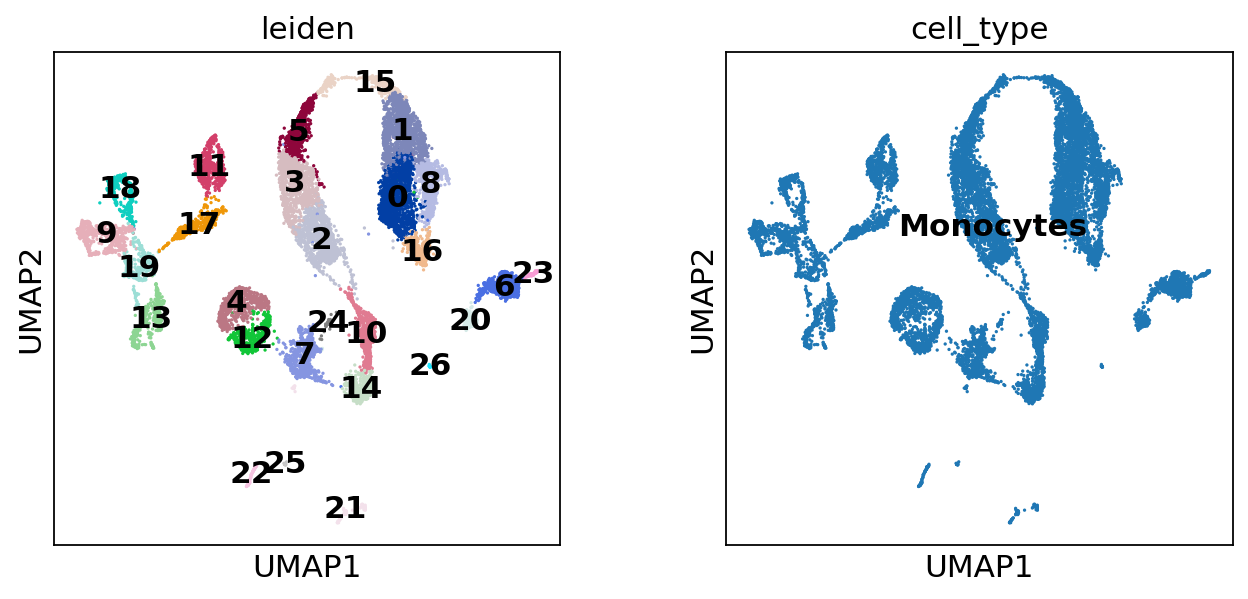

In [62]:
# Annotate cell types
# Define a marker dictionary with mouse genes
mouse_marker_dict = {
    'CD4 T cells': ['Cd4', 'Cd3e', 'Il7r'],
    'CD8 T cells': ['Cd8a', 'Cd3e'],
    'NK cells': ['Nkg7', 'Klrd1'],
    'B cells': ['Cd79a', 'Cd19'],
    'Monocytes': ['Cd14', 'Lyz2'],
    'DCs': ['Fcer1a', 'Itgax'],
    'Platelets': ['Pf4']
}
adata = manual_annotation(adata, marker_dict=mouse_marker_dict)

## Automated Annotation with CellTypist

In [63]:
%%capture
!pip install celltypist

In [142]:
def automated_annotation_celltypist(
    adata,
    model: str = "Immune_All_Low.pkl",
    majority_voting: bool = True,
    label_key: str = "celltypist_prediction",
    confidence_key: str = "celltypist_confidence"
):
    """
    Version-robust automated cell type annotation using CellTypist.
    Works across CellTypist releases with or without `confidence` attribute.
    """
    import scanpy as sc
    import celltypist
    from celltypist import models
    import numpy as np

    # 1. Preconditions
    if adata.raw is None:
        raise ValueError("adata.raw must contain raw counts.")

    # 2. Load model
    models.download_models(force_update=False)
    ct_model = models.Model.load(model=model)

    # 3. Prepare data (CP10K + log1p)
    adata_ct = adata.raw.to_adata()
    sc.pp.normalize_total(adata_ct, target_sum=1e4)
    sc.pp.log1p(adata_ct)

    # 4. Run CellTypist
    predictions = celltypist.annotate(
        adata_ct,
        model=ct_model,
        majority_voting=majority_voting
    )

    # 5. Extract predicted labels (safe for all versions)
    labels = predictions.predicted_labels.iloc[:, 0]
    labels = labels.reindex(adata.obs_names)
    adata.obs[label_key] = labels.astype("category")

    # 6. Derive confidence robustly
    prob = predictions.probability_matrix
    prob = prob.reindex(adata.obs_names)

    confidence = prob.max(axis=1)
    adata.obs[confidence_key] = confidence

    # 7. Optional visualization
    if "X_umap" in adata.obsm:
        sc.pl.umap(
            adata,
            color=[label_key, confidence_key],
            legend_loc="on data",
            frameon=False
        )

    # 8. Sanity check
    assert adata.n_obs == adata.obs[label_key].shape[0]

    return adata

In [146]:
adata.obs

n_genes        batch  n_genes_by_counts  total_counts  \
AAACCTGAGAGCTTCT-1     2555        S1_WT               2555        6800.0   
AAACCTGAGAGTACCG-1     1489        S1_WT               1489        3213.0   
AAACCTGAGCCCTAAT-1     1909        S1_WT               1909        4085.0   
AAACCTGAGTGGGATC-1     1926        S1_WT               1926        4511.0   
AAACCTGCACAACTGT-1     2892        S1_WT               2892        8405.0   
...                     ...          ...                ...           ...   
TTTGTTGAGCGTTCAT-1     4778  S2_Fefz2-KO               4778       19368.0   
TTTGTTGCAATACAGA-1     3248  S2_Fefz2-KO               3248        8002.0   
TTTGTTGGTACCAATC-1     1591  S2_Fefz2-KO               1591        2769.0   
TTTGTTGGTATGATCC-1     2584  S2_Fefz2-KO               2584        6194.0   
TTTGTTGGTGATTAGA-1     2140  S2_Fefz2-KO               2140        5284.0   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCTGAGAGCTTCT-1            374.0       5.500000              882.0   
AAACCTGAGAGTACCG-1            278.0       8.652349              481.0   
AAACCTGAGCCCTAAT-1             99.0       2.423501              595.0   
AAACCTGAGTGGGATC-1            240.0       5.320328              612.0   
AAACCTGCACAACTGT-1            386.0       4.592505             1484.0   
...                             ...            ...                ...   
TTTGTTGAGCGTTCAT-1           1478.0       7.631144             2119.0   
TTTGTTGCAATACAGA-1            652.0       8.147964              769.0   
TTTGTTGGTACCAATC-1            209.0       7.547851              184.0   
TTTGTTGGTATGATCC-1            383.0       6.183403              743.0   
TTTGTTGGTGATTAGA-1            287.0       5.431491              755.0   

                    pct_counts_ribo  total_counts_hb  pct_counts_hb  \
AAACCTGAGAGCTTCT-1        12.970588              0.0        0.00000   
AAACCTGAGAGTACCG-1        14.970432              0.0        0.00000   
AAACCTGAGCCCTAAT-1        14.565483              1.0        0.02448   
AAACCTGAGTGGGATC-1        13.566836              0.0        0.00000   
AAACCTGCACAACTGT-1        17.656157              0.0        0.00000   
...                             ...              ...            ...   
TTTGTTGAGCGTTCAT-1        10.940727              0.0        0.00000   
TTTGTTGCAATACAGA-1         9.610097              0.0        0.00000   
TTTGTTGGTACCAATC-1         6.644999              0.0        0.00000   
TTTGTTGGTATGATCC-1        11.995480              0.0        0.00000   
TTTGTTGGTGATTAGA-1        14.288418              0.0        0.00000   

                    log10_total_counts leiden       celltypist_prediction  \
AAACCTGAGAGCTTCT-1            3.832573      0  Double-positive thymocytes   
AAACCTGAGAGTACCG-1            3.507046      0  Double-positive thymocytes   
AAACCTGAGCCCTAAT-1            3.611298     19  Double-positive thymocytes   
AAACCTGAGTGGGATC-1            3.654369      0  Double-positive thymocytes   
AAACCTGCACAACTGT-1            3.924590      1  Double-positive thymocytes   
...                                ...    ...                         ...   
TTTGTTGAGCGTTCAT-1            4.287107      3  Double-positive thymocytes   
TTTGTTGCAATACAGA-1            3.903253      2  Double-positive thymocytes   
TTTGTTGGTACCAATC-1            3.442480     15  Double-positive thymocytes   
TTTGTTGGTATGATCC-1            3.792042     15  Double-positive thymocytes   
TTTGTTGGTGATTAGA-1            3.723045     19  Double-positive thymocytes   

                   louvain spectral  celltypist_confidence  
AAACCTGAGAGCTTCT-1       0        7               0.002548  
AAACCTGAGAGTACCG-1       4        7               0.002548  
AAACCTGAGCCCTAAT-1      10       23               0.002548  
AAACCTGAGTGGGATC-1       4        7               0.002548  
AAACCTGCACAACTGT-1       0        1               0.002548  
...                    ...      ...                    ...  
TTTGTTGAGCGTT

In [147]:
adata.obs['celltypist_prediction'].value_counts()

celltypist_prediction
Double-positive thymocytes    12567
Epithelial cells               1022
Fibroblasts                      15
Name: count, dtype: int64

In [149]:
adata.n_obs

13604

normalizing counts per cell
    finished (0:00:00)
running Leiden clustering
    finished: found 102 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


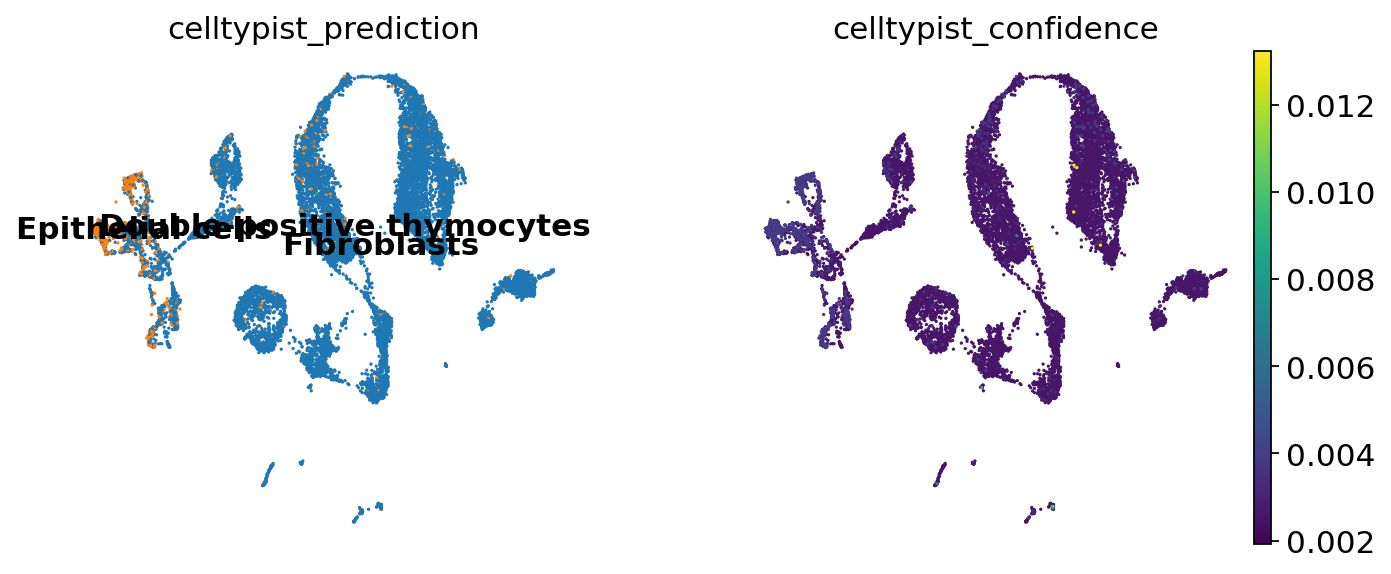

In [145]:
# Example usage (requires celltypist installation)
adata = automated_annotation_celltypist(adata)

## Trajectory Analysis


### Pseudotime Analysis with Diffusion Pseudotime

In [151]:
def calculate_pseudotime(adata, root_cluster='0', groupby='leiden'):
    """
    Calculate pseudotime using diffusion maps

    Parameters:
    -----------
    root_cluster : str
        Cluster to use as root for pseudotime
    """

    # Calculate diffusion map if not already done
    if 'X_diffmap' not in adata.obsm:
        sc.tl.diffmap(adata)

    # Set root cell (cell with highest expression of root markers)
    root_mask = adata.obs[groupby] == root_cluster
    root_indices = np.where(root_mask)[0]

    # Use the cell closest to the median of the root cluster
    root_cell = root_indices[0]
    adata.uns['iroot'] = root_cell

    # Calculate diffusion pseudotime
    sc.tl.dpt(adata)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sc.pl.umap(adata, color=groupby, ax=axes[0], show=False, title='Clusters')
    sc.pl.umap(adata, color='dpt_pseudotime', ax=axes[1], show=False, title='Pseudotime')
    sc.pl.diffmap(adata, color='dpt_pseudotime', ax=axes[2], show=False)
    plt.tight_layout()
    plt.show()

    return adata

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9970595  0.99621046 0.9952506  0.9939466  0.993328
     0.99209344 0.99046963 0.98976207 0.9883193  0.98660254 0.9861578
     0.98586905 0.9852647  0.9841907 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


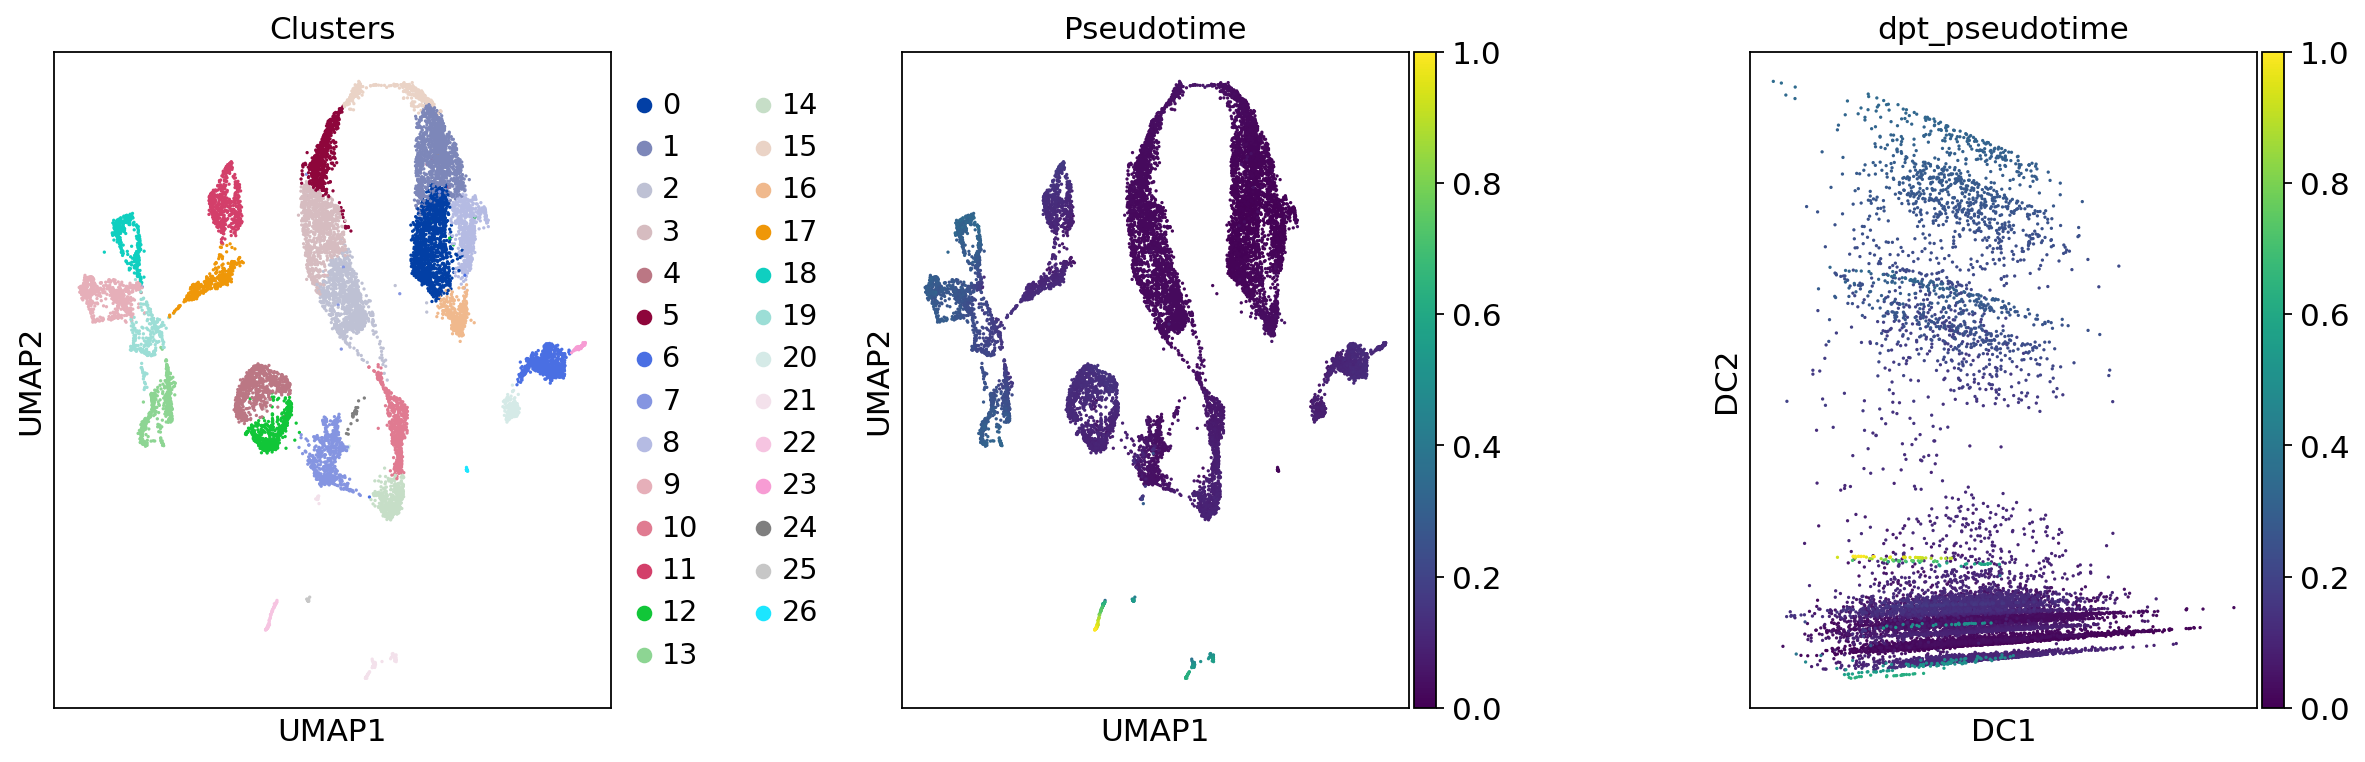

In [152]:
# Calculate pseudotime
adata = calculate_pseudotime(adata, root_cluster='0')

In [153]:
adata

AnnData object with n_obs × n_vars = 13604 × 2000
    obs: 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'leiden', 'celltypist_prediction', 'louvain', 'spectral', 'celltypist_confidence', 'dpt_pseudotime'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'leiden_0.1', 'leiden_0.2', 'leiden_0.30000000000000004', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7000000000000001', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2000000000000002', 'leiden_1.3000000000000003', 'leiden_1.4000000000000001', 'leiden_1.5000000000000002', 'leiden_1.6', 'leiden_1.7000000000000002', 'leiden_1.8000000000000003', 'leiden_1.9000000000000001', 'lei

### RNA Velocity Analysis

In [154]:
def run_velocity_analysis(adata, loom_file=None):
    """
    Run RNA velocity analysis using scVelo

    Parameters:
    -----------
    loom_file : str
        Path to loom file with spliced/unspliced counts
    """
    import scvelo as scv

    if loom_file:
        # Load velocity data
        ldata = scv.read(loom_file, cache=True)

        # Merge with adata
        adata = scv.utils.merge(adata, ldata)

    # Preprocess
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    # Run velocity
    scv.tl.velocity(adata)
    scv.tl.velocity_graph(adata)

    # Project velocity
    scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden')

    # Calculate velocity confidence
    scv.tl.velocity_confidence(adata)

    # Visualize
    scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

    return adata

In [ ]:
# Example usage (requires loom file)
adata = run_velocity_analysis(adata, loom_file='velocyto_output.loom')